In [1]:
import sys, os; sys.path.insert(0, os.path.abspath('..'))
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
import logging
logging.getLogger().setLevel(logging.CRITICAL)

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

from src.utils import (get_data, features, target, cv_splits_no_val, partial_days, full_days, weekends, split_dataset_by_dates, optimize_model_with_custom_splits, 
evaluate_and_visualize_model, get_index_for_days, get_cv_days)
from src.pipeline import get_pipeline, CustomTimeSeriesSplitter
from src.plotting import plot_param_importances
from src.feature_groups import temperature_features, humidity_features, light_features, humidity_ratio_features, co2_features

In [2]:
df, df_test, df_training, df_test_2 = get_data()

In [3]:
to_remove = ['Index', 'num', 'Occupancy', 'Light_pct_change']
features = [x for x in df.columns if x not in to_remove]

In [4]:
X_train, y_train, X_val, y_val, _, _ = split_dataset_by_dates(df, features, target, train_dates=partial_days[:-1]+weekends[:-1]+full_days[:-2], 
                                                                        test_dates=full_days[-2:]+weekends[-1:]+partial_days[-1:])

In [5]:
all_cv_days = get_cv_days(cv_splits_no_val)
df_cv = df.iloc[get_index_for_days(df.index, all_cv_days)].copy()

cv_splitter = CustomTimeSeriesSplitter(cv_splits_no_val, df_cv.index)

In [6]:
linear_pipeline = get_pipeline(model=LogisticRegression)

In [7]:
linear_params = {
    'model__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # default: 1.0
    'model__penalty': ['l1', 'l2', 'elasticnet'],  # default: 'l2'
    'model__solver': ['lbfgs', 'saga'],  # default: 'lbfgs'
    'model__class_weight': ['balanced', None, {0: 1, 1: 2}, {0: 1, 1: 3}],  # default: None
    'model__max_iter': [3000],  # default: 100
    'model__random_state': [42],
    'historic_feature__add_feature': [True],
    'historic_feature__period_length': [5, 15, 30, 60],
    'feature_selector__feature_selection': [
        ['Light'], ['Light', 'Light_lag_1min'], ['Light', 'CO2'], ['Light', 'HumidityRatio'], ['Light', 'HumidityRatio', 'CO2'], 
        ['Light', 'HumidityRatio', 'CO2', 'Temperature'], ['Light', 'HumidityRatio', 'CO2', 'Temperature', 'Humidity'],
        ['Light', 'HumidityRatio', 'Light_lag_1min'], ['Light', 'HumidityRatio', 'CO2', 'Light_lag_1min'],
        ['Light', 'HumidityRatio', 'CO2', 'Temperature', 'Light_lag_1min'], ['Light', 'HumidityRatio', 'CO2', 'Temperature', 'Humidity', 'Light_lag_1min'],
        ['Light', 'CO2', 'Temperature', 'Humidity', 'Light_lag_1min']
        ]
}

# Note: For 'elasticnet' penalty, only 'saga' solver is supported
# For class imbalance, 'balanced' or custom weights like {0: 1, 1: 2} or {0: 1, 1: 3} may help

In [8]:
best_linear_pipeline, linear_cv_results, best_linear_params, best_linear_score = optimize_model_with_custom_splits(df_cv, 
                                features, target, cv_splitter, linear_pipeline, linear_params, n_iter=100, n_jobs=-1,
                                  scoring='f1', random_state=42)

# Note: some parameter combinations do not work. That is why there are Errors/Warnings

/Users/a844494/.pyenv/versions/bayesian/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/a844494/.pyenv/versions/bayesian/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/a844494/.pyenv/versions/bayesian/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/a844494/.pyenv/versions/

Best parameters: {'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'l1', 'model__max_iter': 3000, 'model__class_weight': 'balanced', 'model__C': 100.0, 'historic_feature__period_length': 15, 'historic_feature__add_feature': True, 'feature_selector__feature_selection': ['Light', 'CO2', 'Temperature', 'Humidity', 'Light_lag_1min']}
Best CV score: 0.9673

Performance across splits:
  first_split: Test=0.9861, Train=0.9746
  second_split: Test=0.9667, Train=0.9826
  third_split: Test=0.9083, Train=0.9868
  fourth_split: Test=0.9867, Train=0.9708
  fifth_split: Test=0.9888, Train=0.9668


input features: Index(['Light', 'CO2', 'Temperature', 'Humidity', 'Light_lag_1min',
       'historic_occupancy'],
      dtype='object')
Model Evaluation Summary:
----------------------------------------
Train Set Metrics:
  Accuracy:  0.9909
  Precision: 0.9631
  Recall:    0.9962
  F1 Score:  0.9794
  ROC AUC:   0.9984
----------------------------------------
Test Set Metrics:
  Accuracy:  0.9776
  Precision: 0.9254
  Recall:    0.9985
  F1 Score:  0.9605
  ROC AUC:   0.9911
----------------------------------------

--- Training Set Misclassifications ---
Found classification errors on 12 days.
Date: 2015-02-04 / Day (07–19), Wednesday: 17 errors out of 293 records (5.80%)


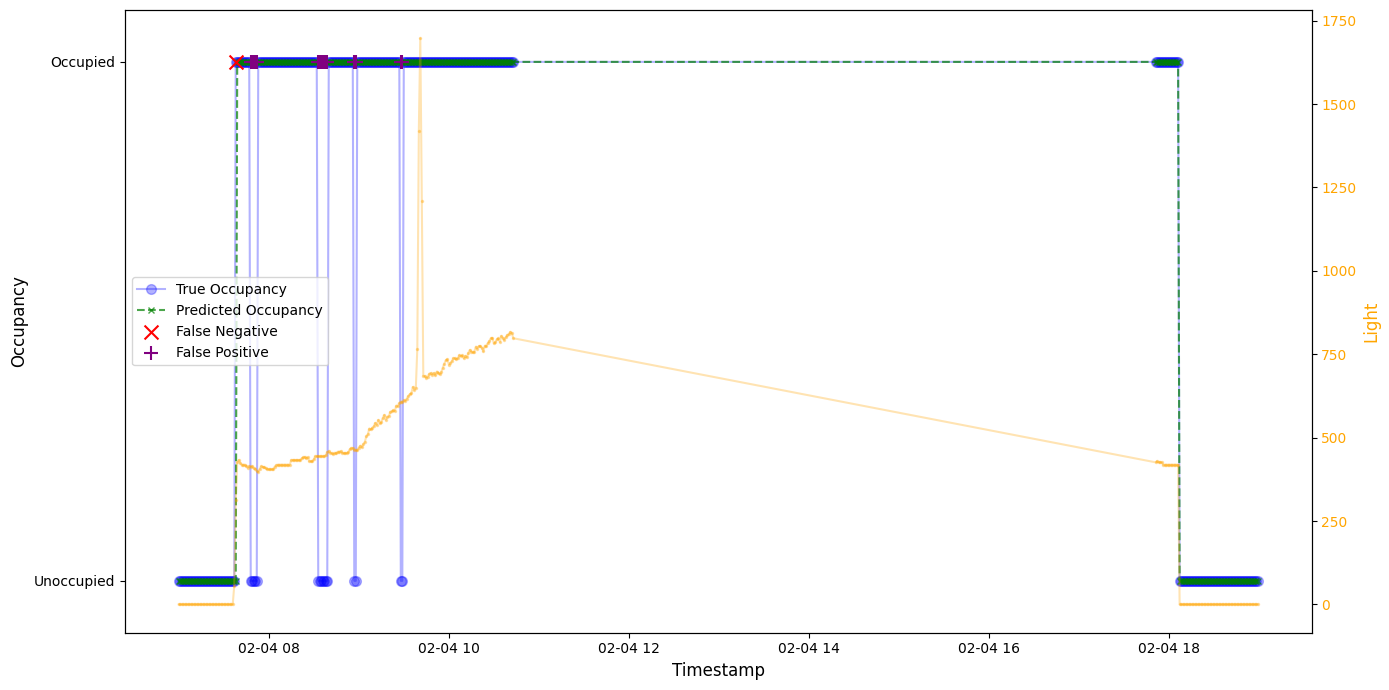

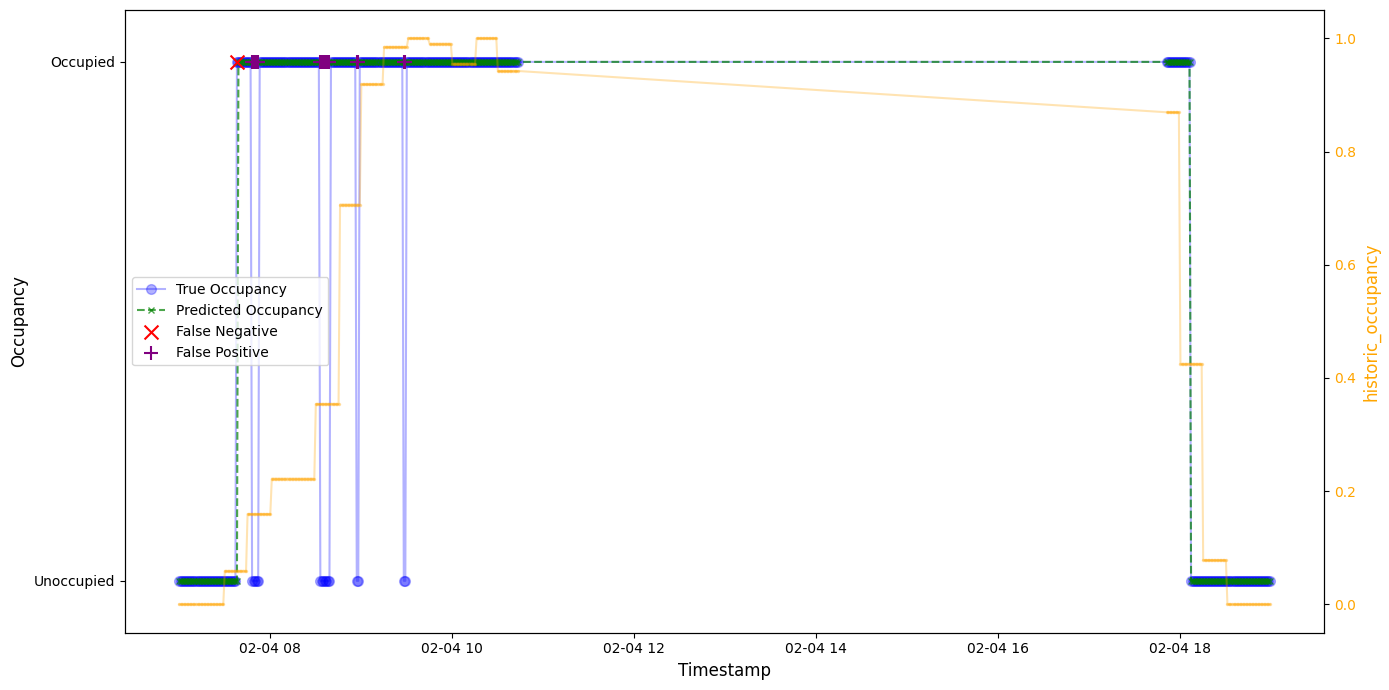

Date: 2015-02-06 / Day (07–19), Friday: 18 errors out of 720 records (2.50%)


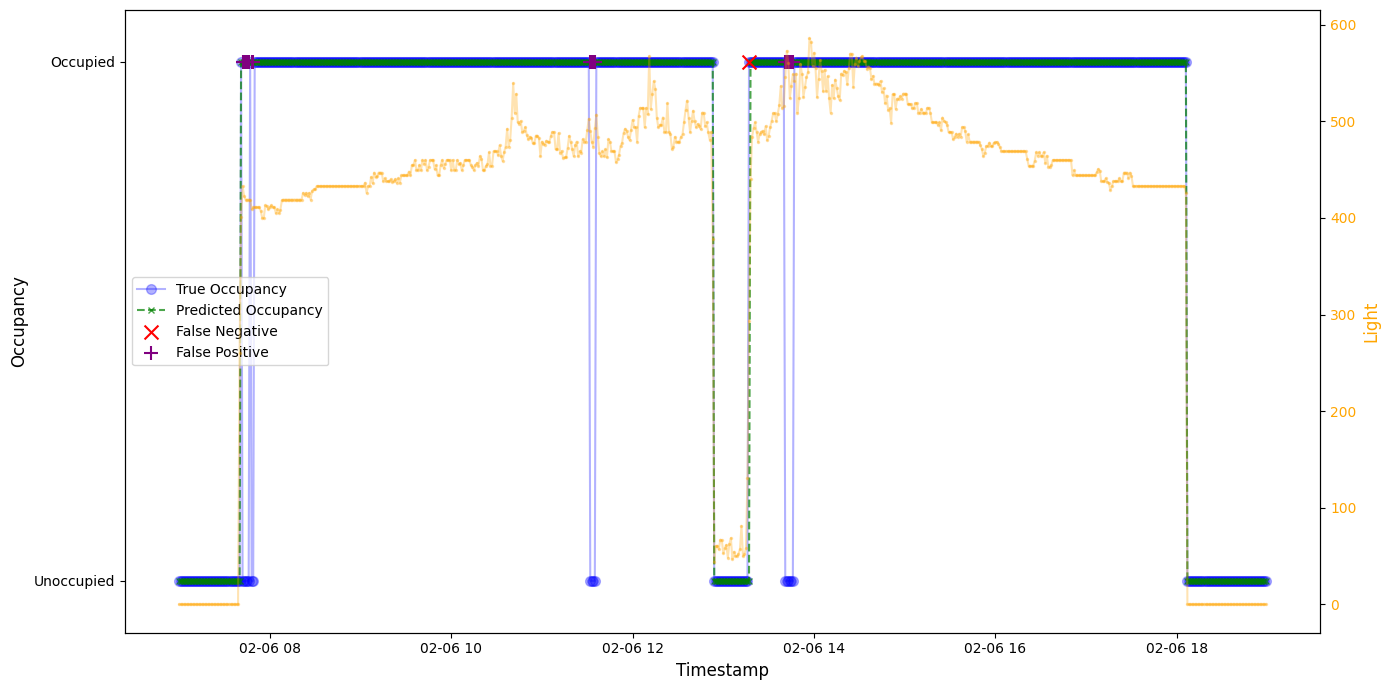

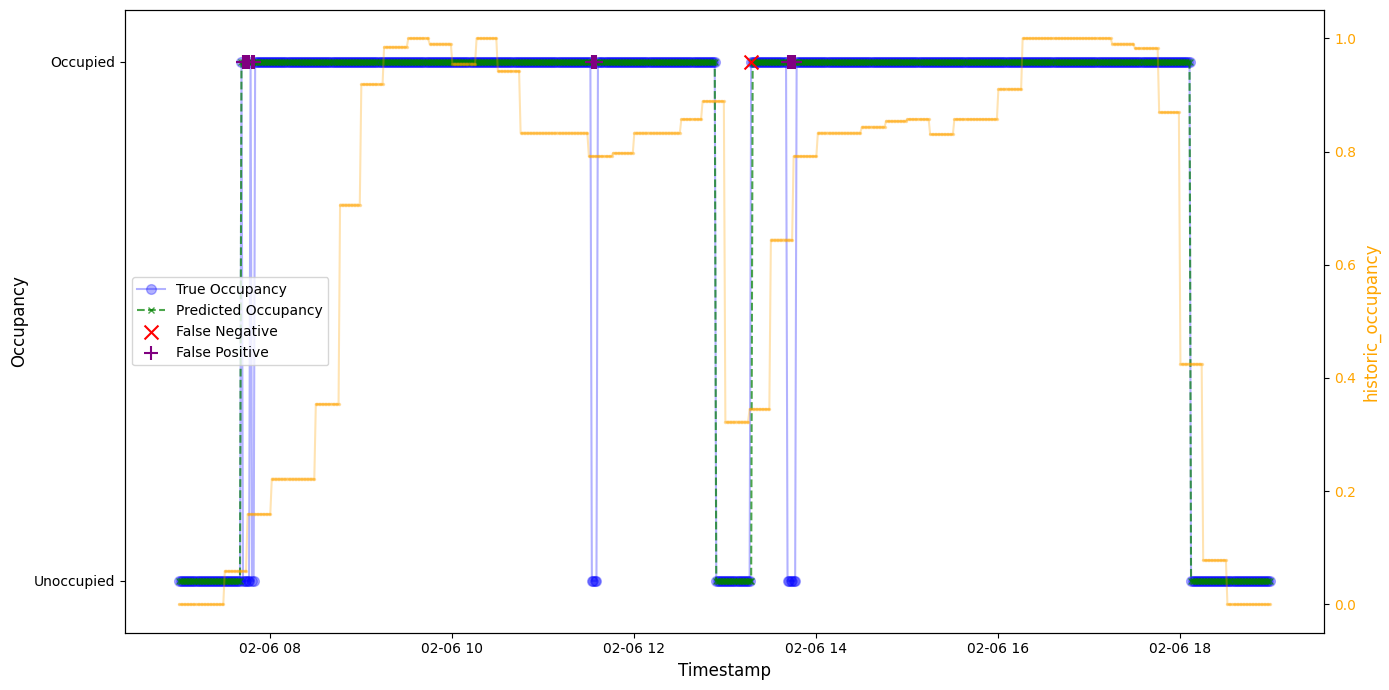

Date: 2015-02-07 / Day (07–19), Saturday: 4 errors out of 720 records (0.56%)


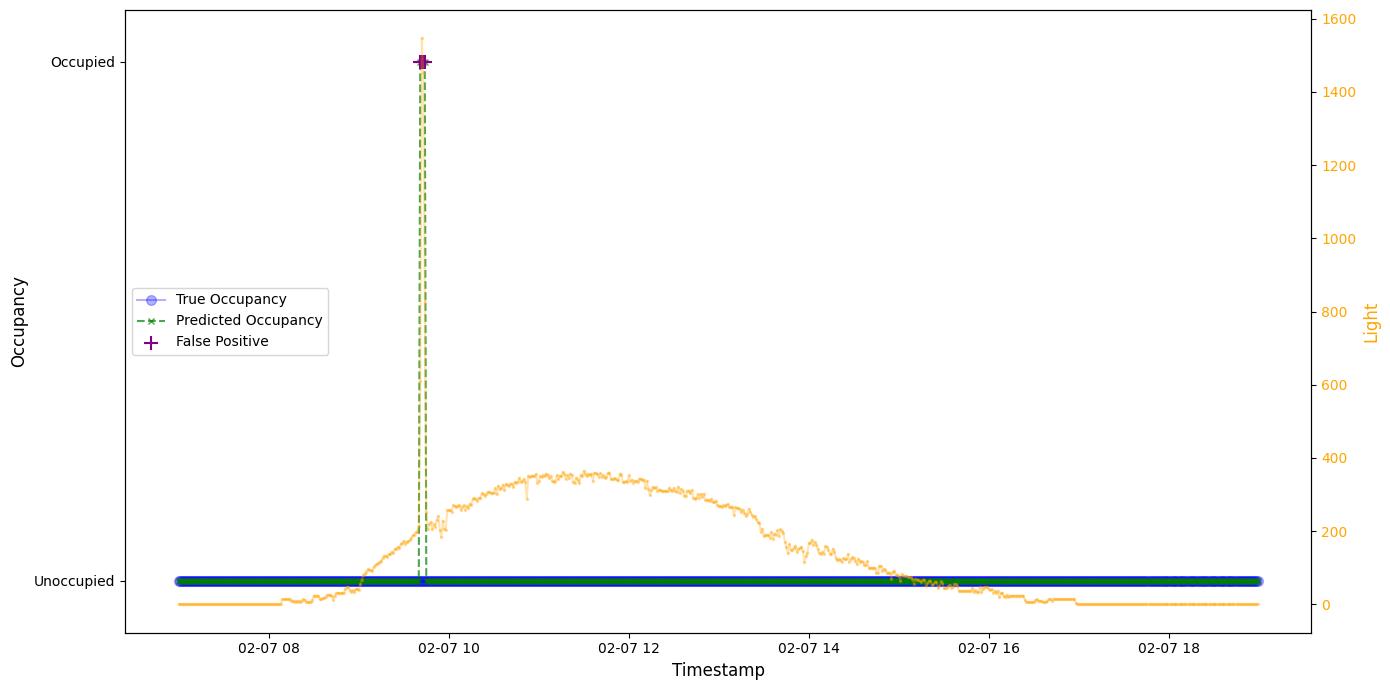

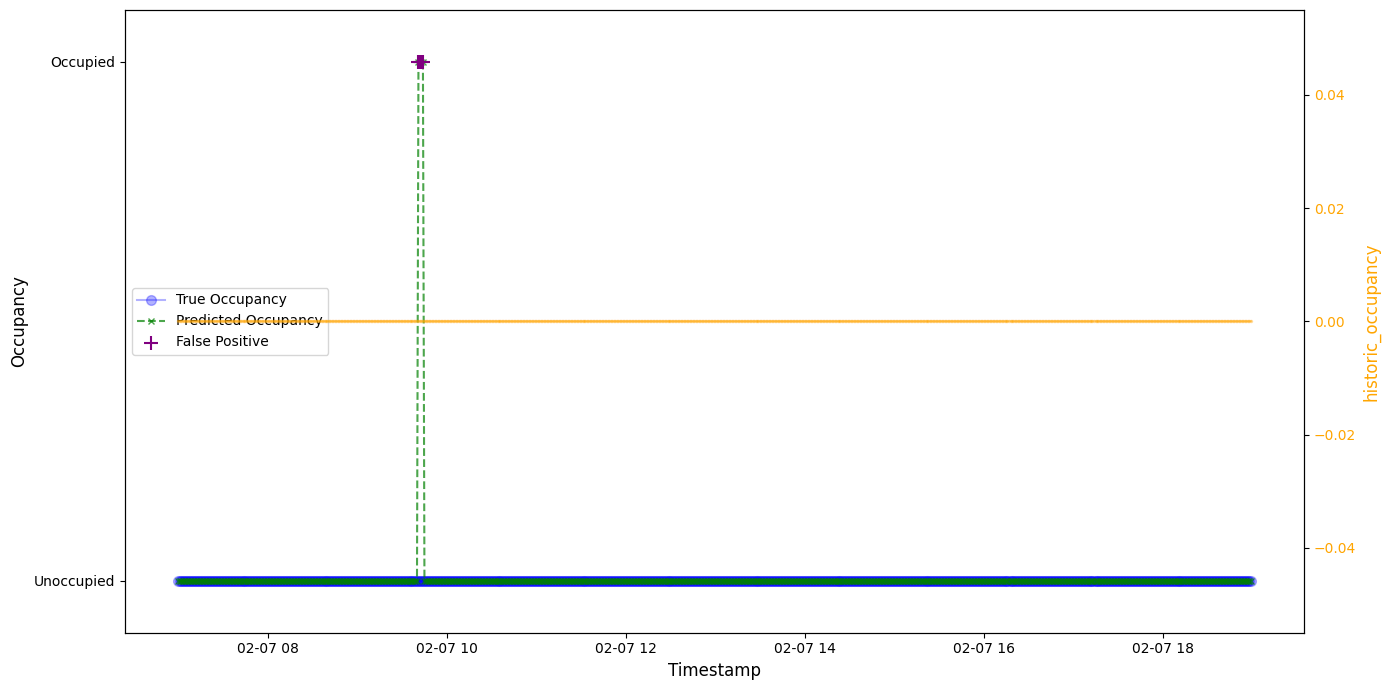

Date: 2015-02-08 / Day (07–19), Sunday: 8 errors out of 720 records (1.11%)


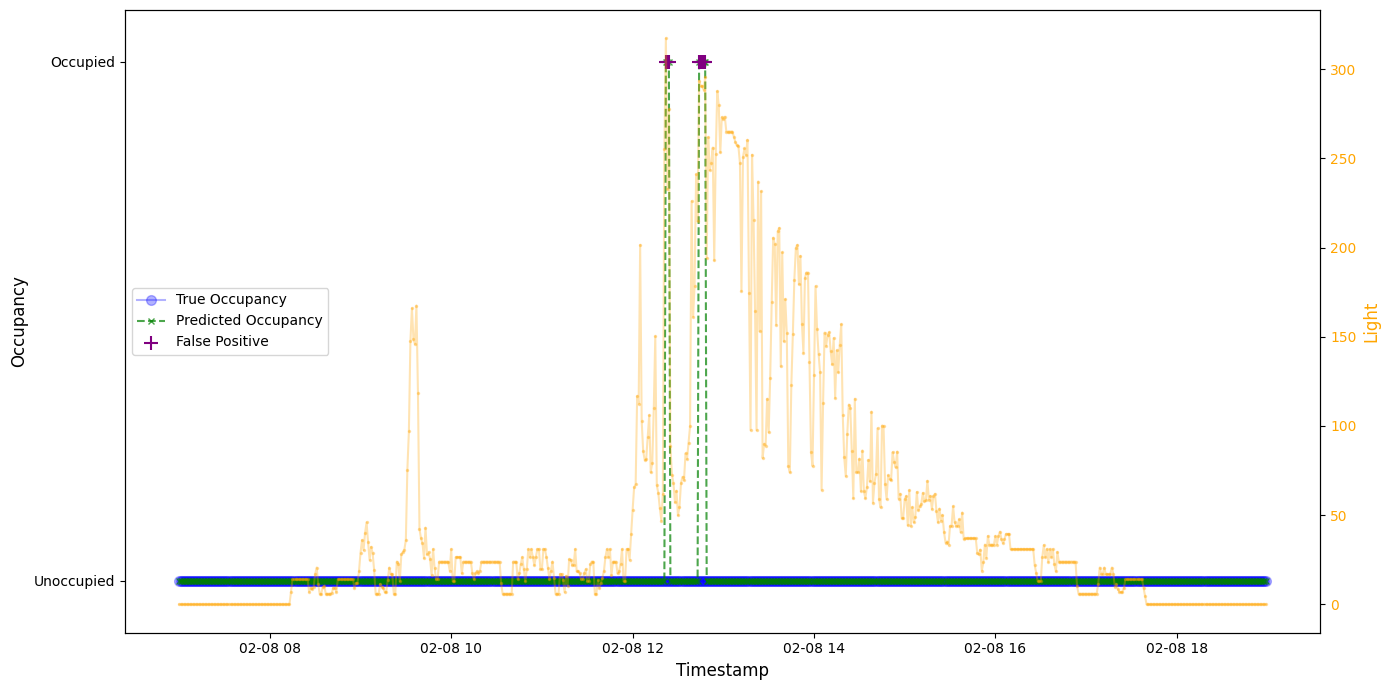

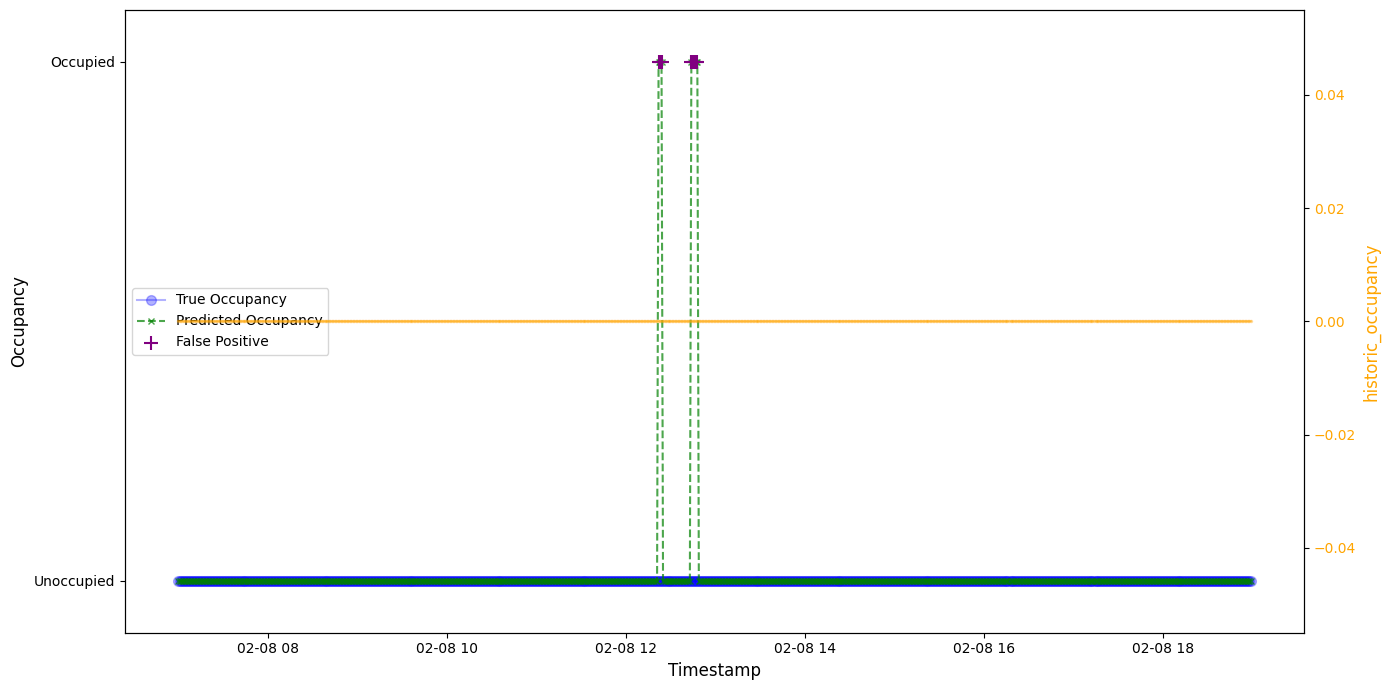

Date: 2015-02-09 / Day (07–19), Monday: 5 errors out of 720 records (0.69%)


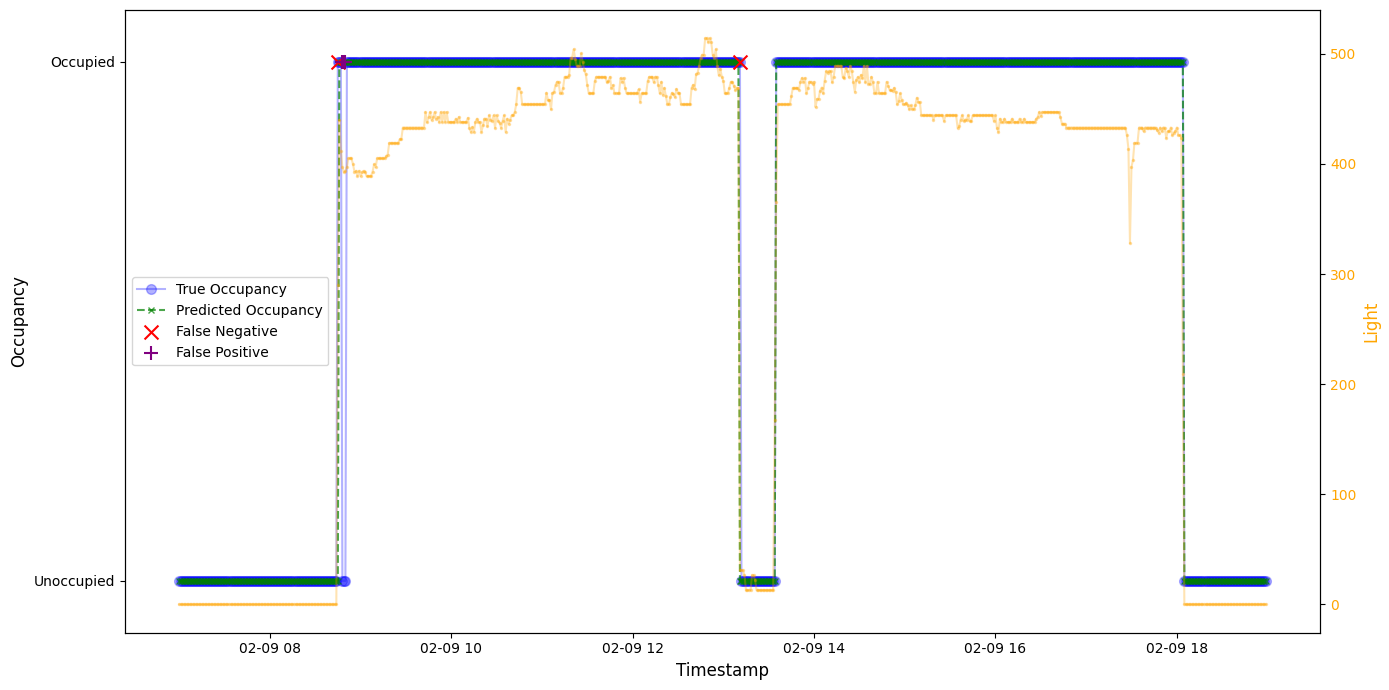

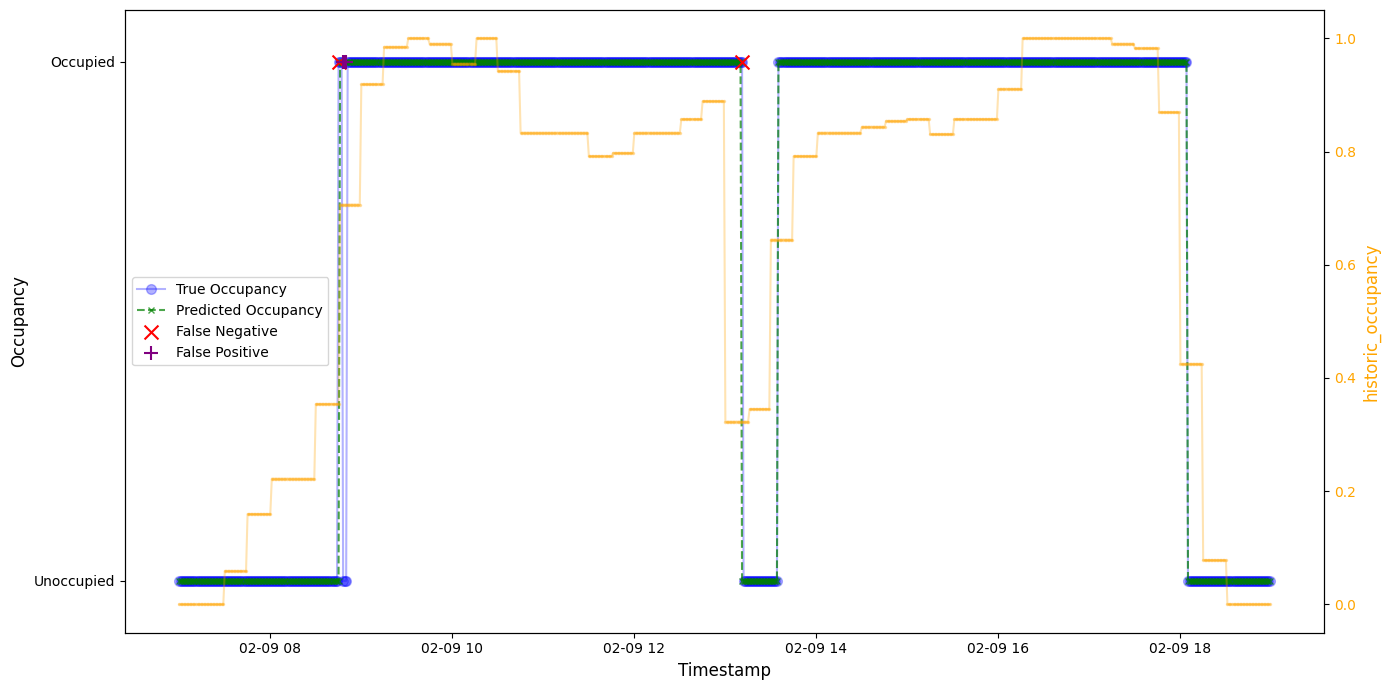

Date: 2015-02-10 / Day (07–19), Tuesday: 2 errors out of 154 records (1.30%)


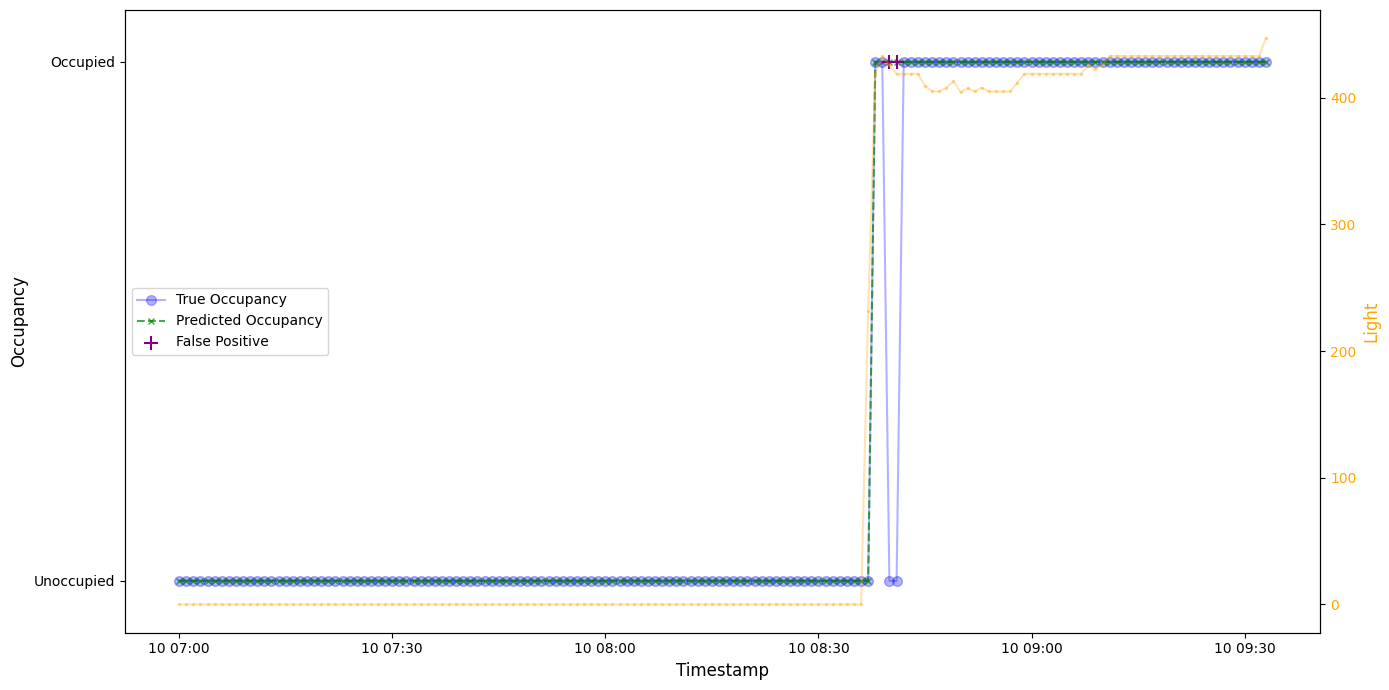

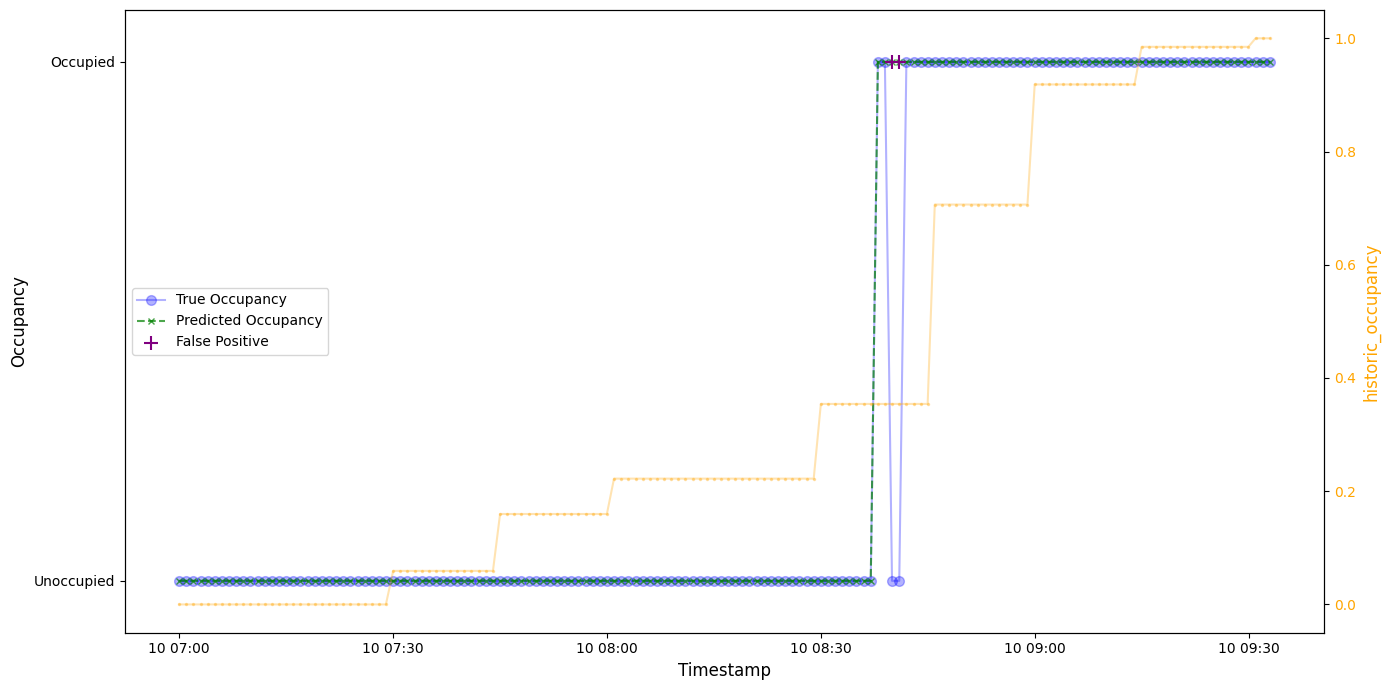

Date: 2015-02-11 / Day (07–19), Wednesday: 4 errors out of 252 records (1.59%)


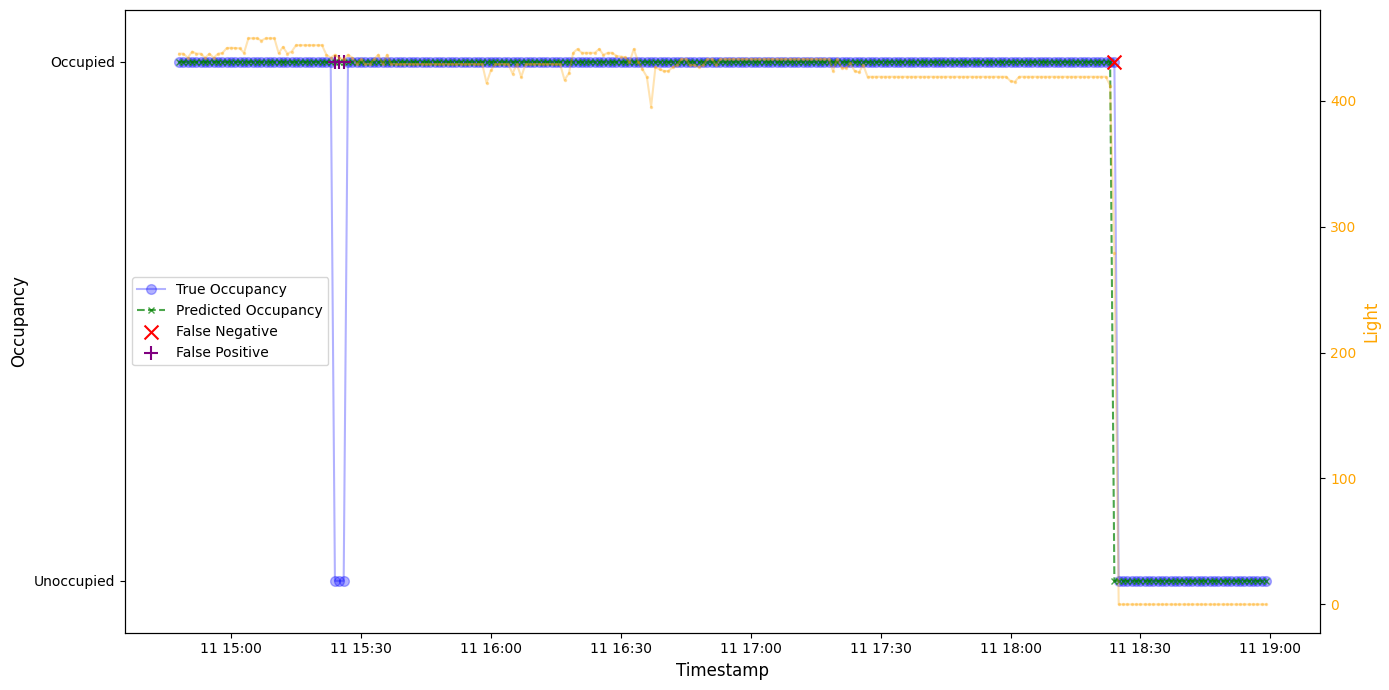

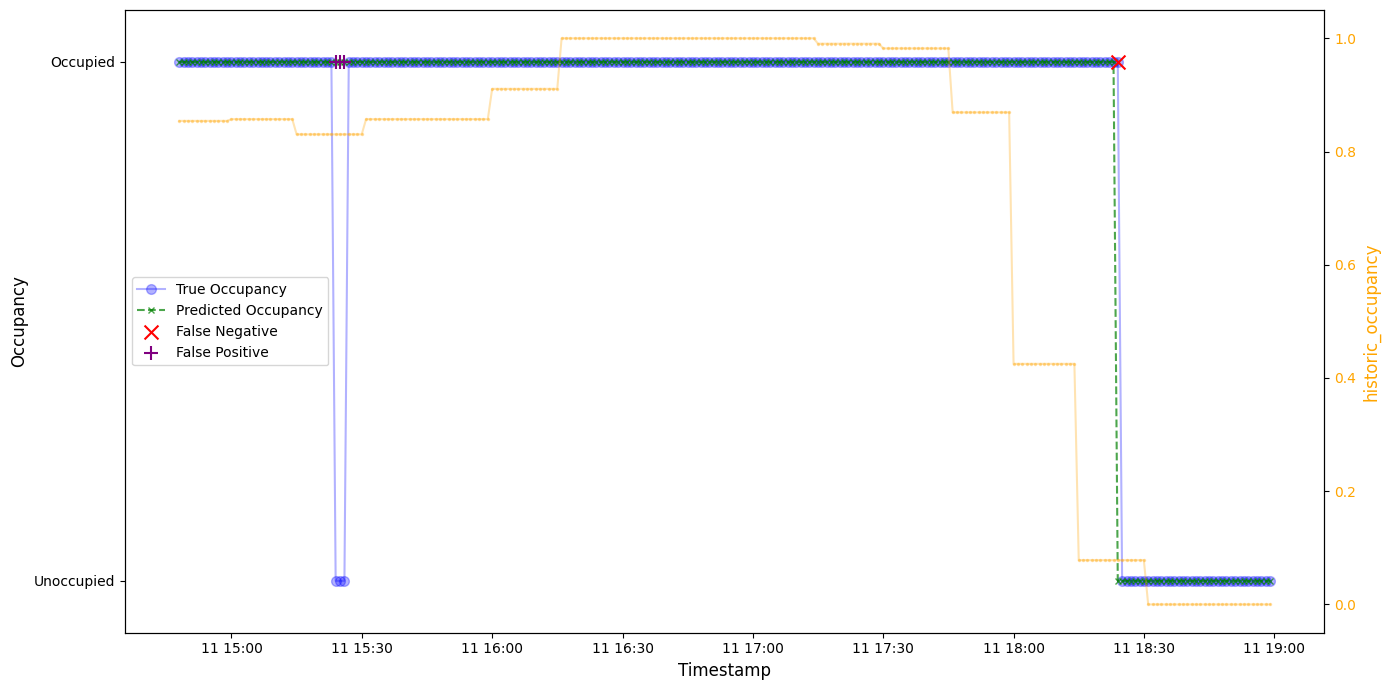

Date: 2015-02-12 / Day (07–19), Thursday: 42 errors out of 720 records (5.83%)


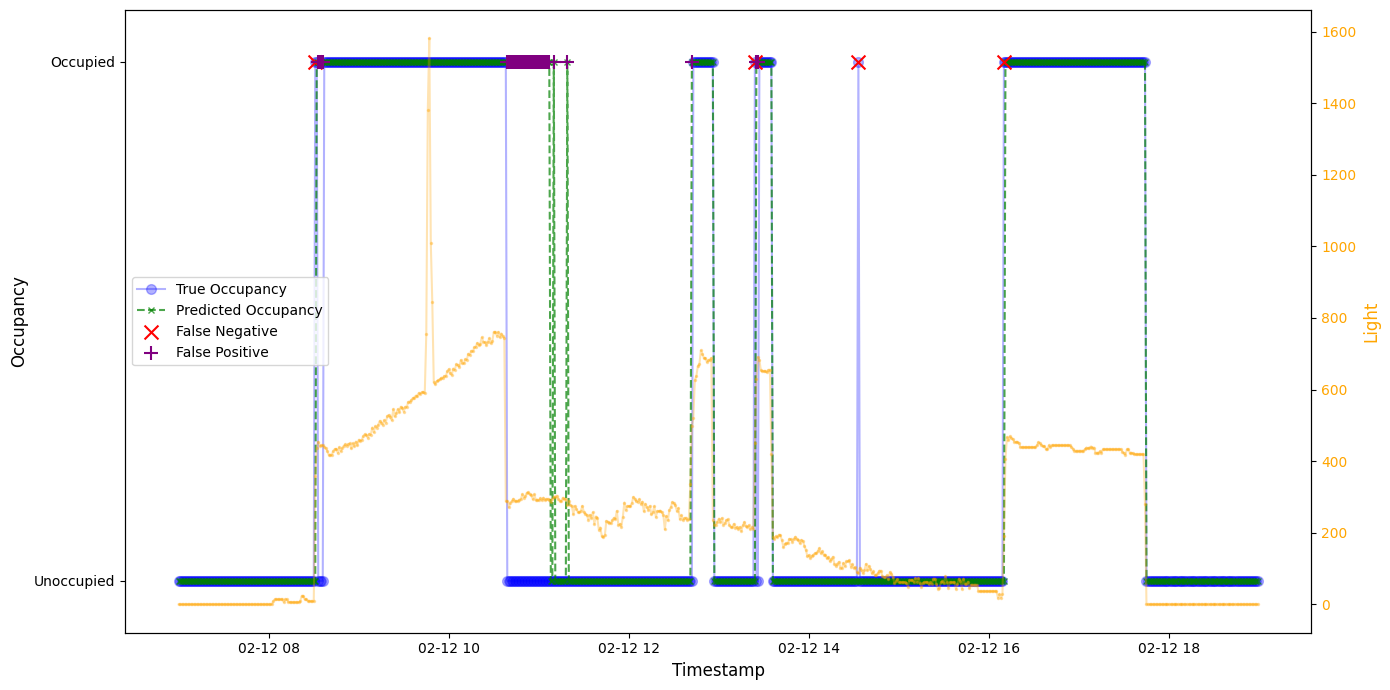

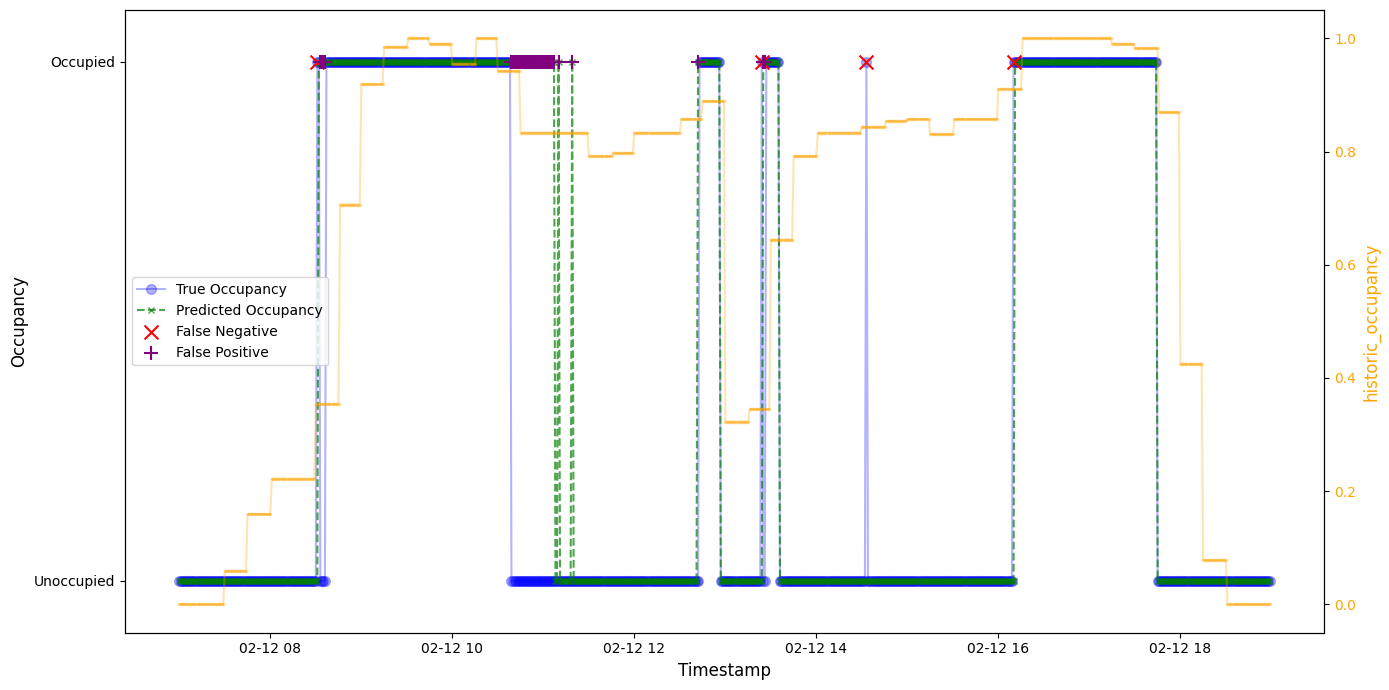

Date: 2015-02-13 / Day (07–19), Friday: 21 errors out of 720 records (2.92%)


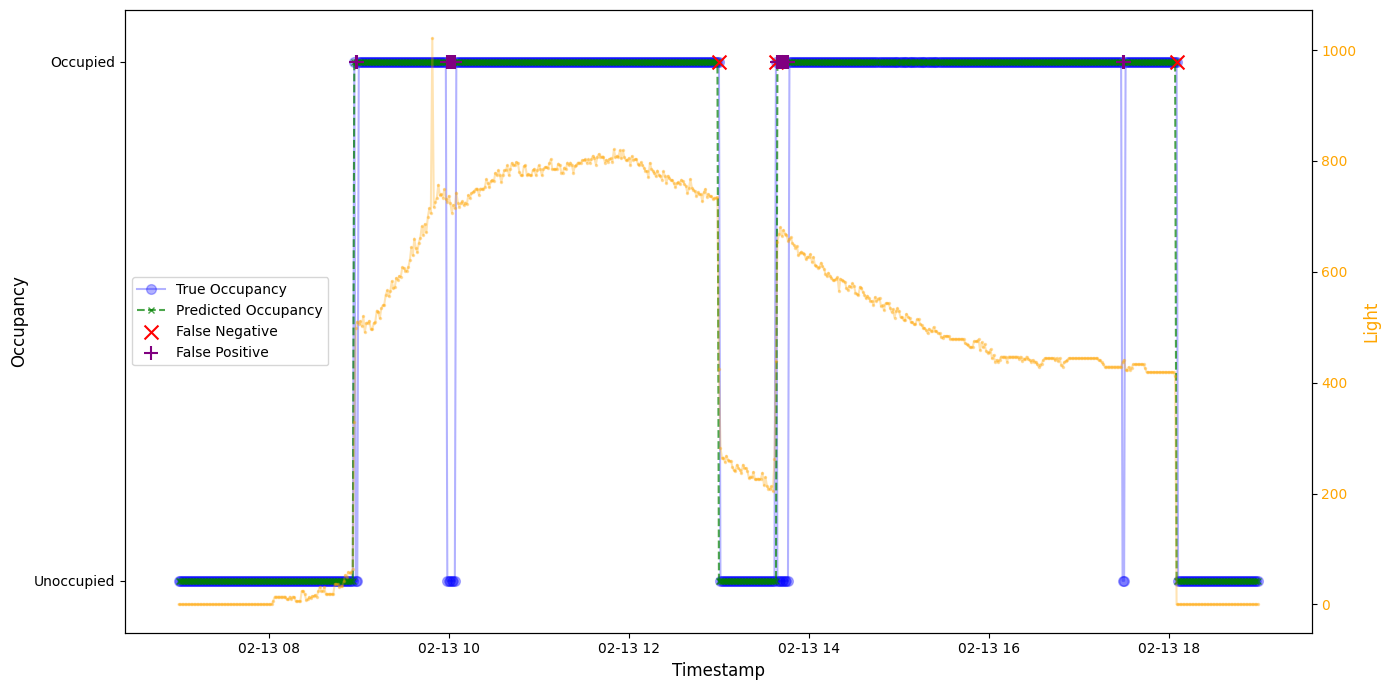

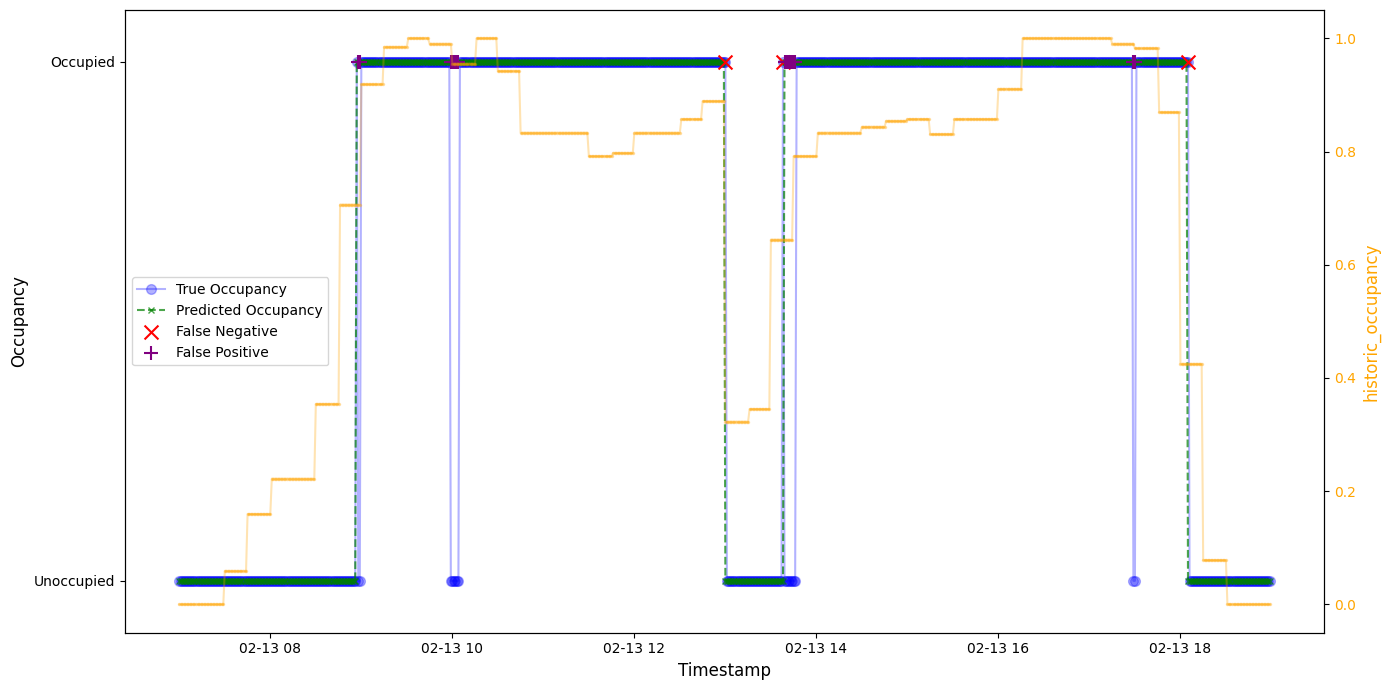

Date: 2015-02-14 / Day (07–19), Saturday: 4 errors out of 720 records (0.56%)


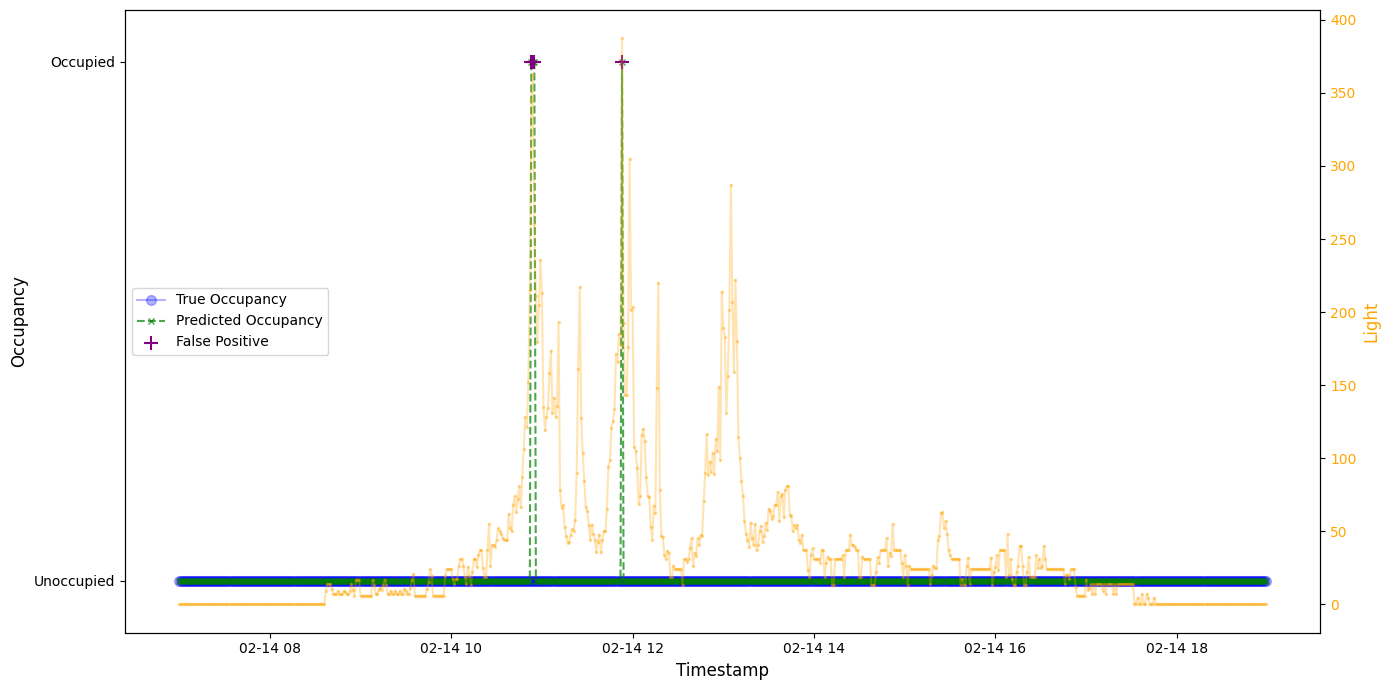

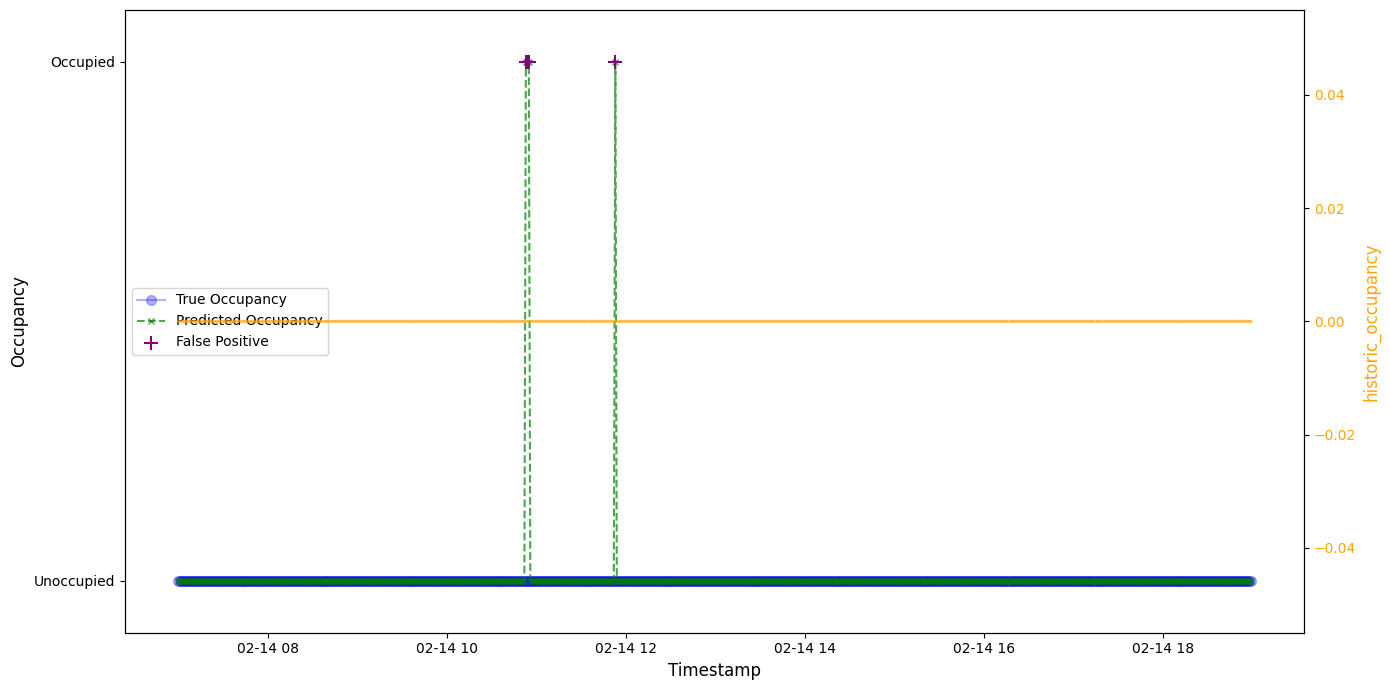

Date: 2015-02-16 / Day (07–19), Monday: 11 errors out of 720 records (1.53%)


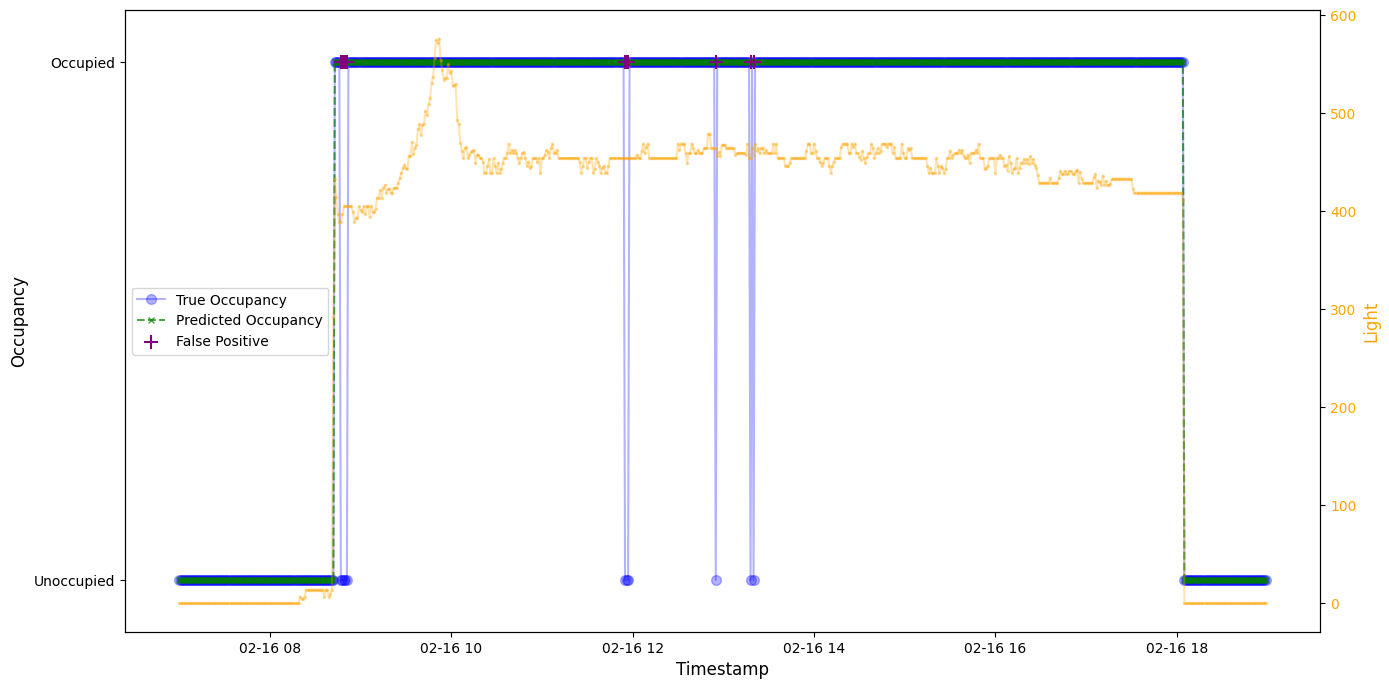

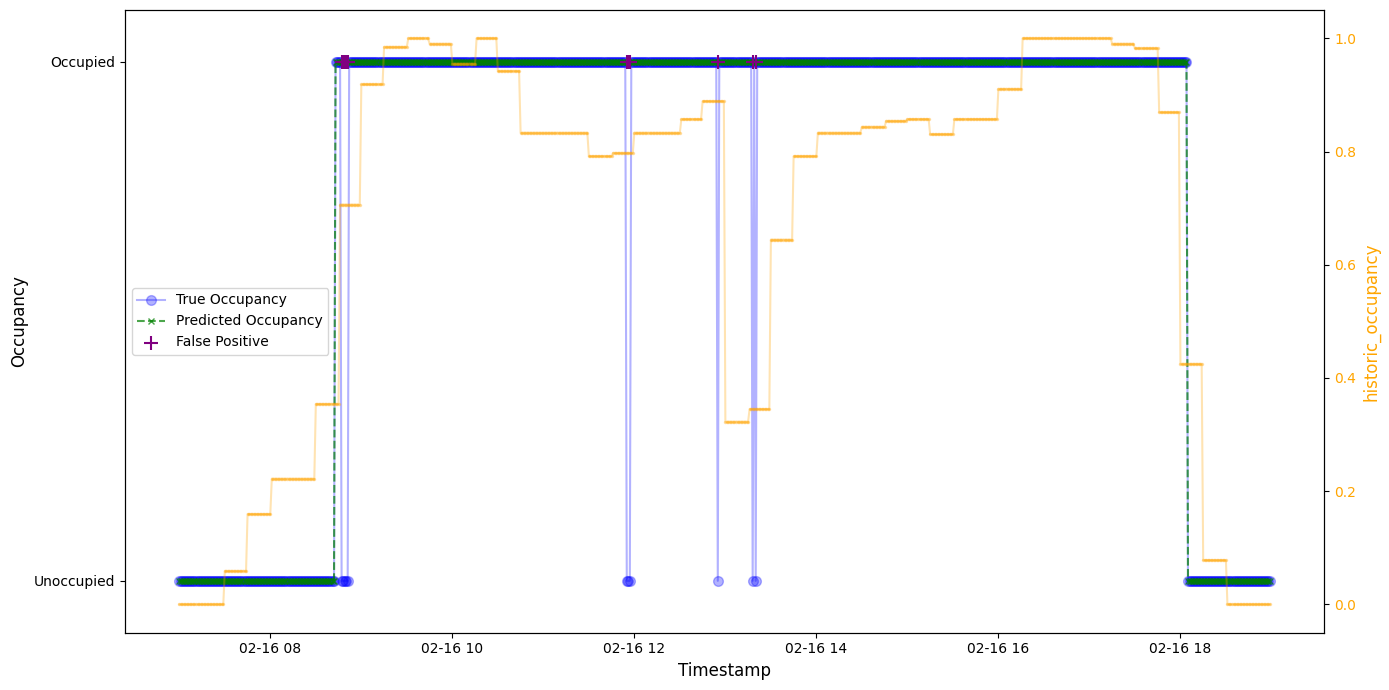

Date: 2015-02-17 / Day (07–19), Tuesday: 7 errors out of 720 records (0.97%)


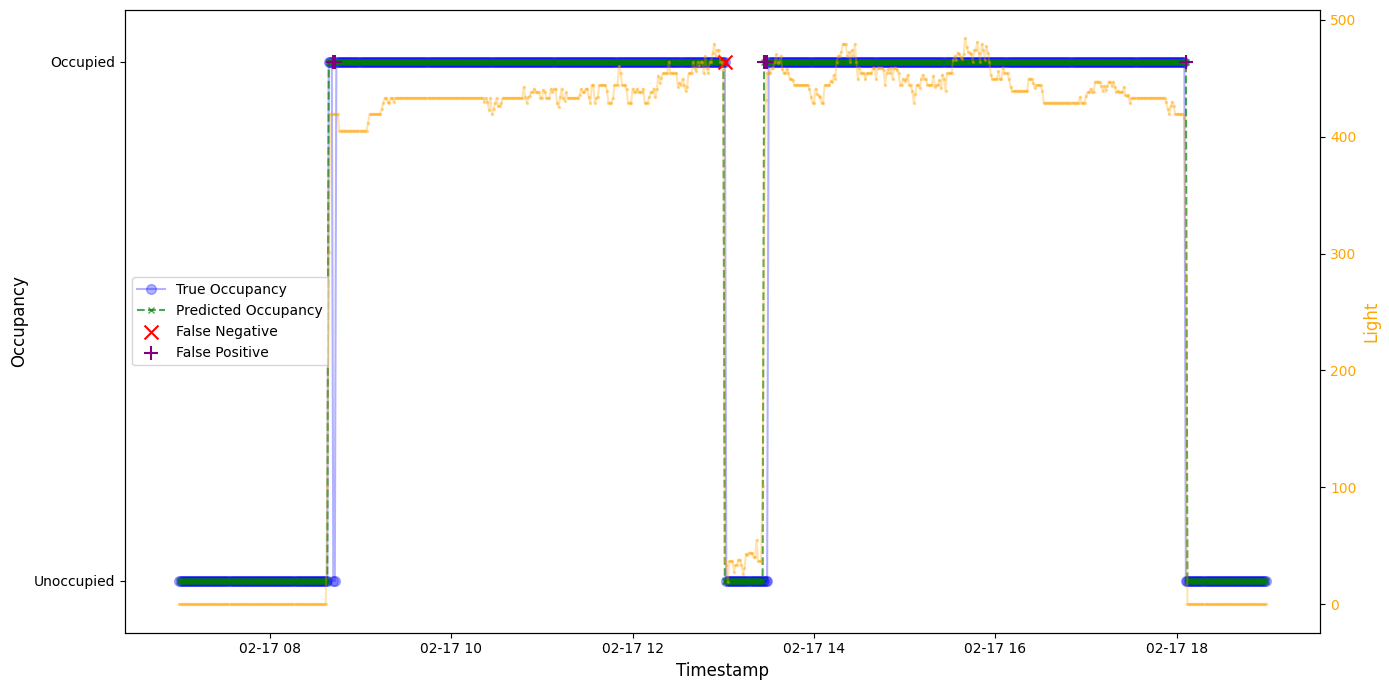

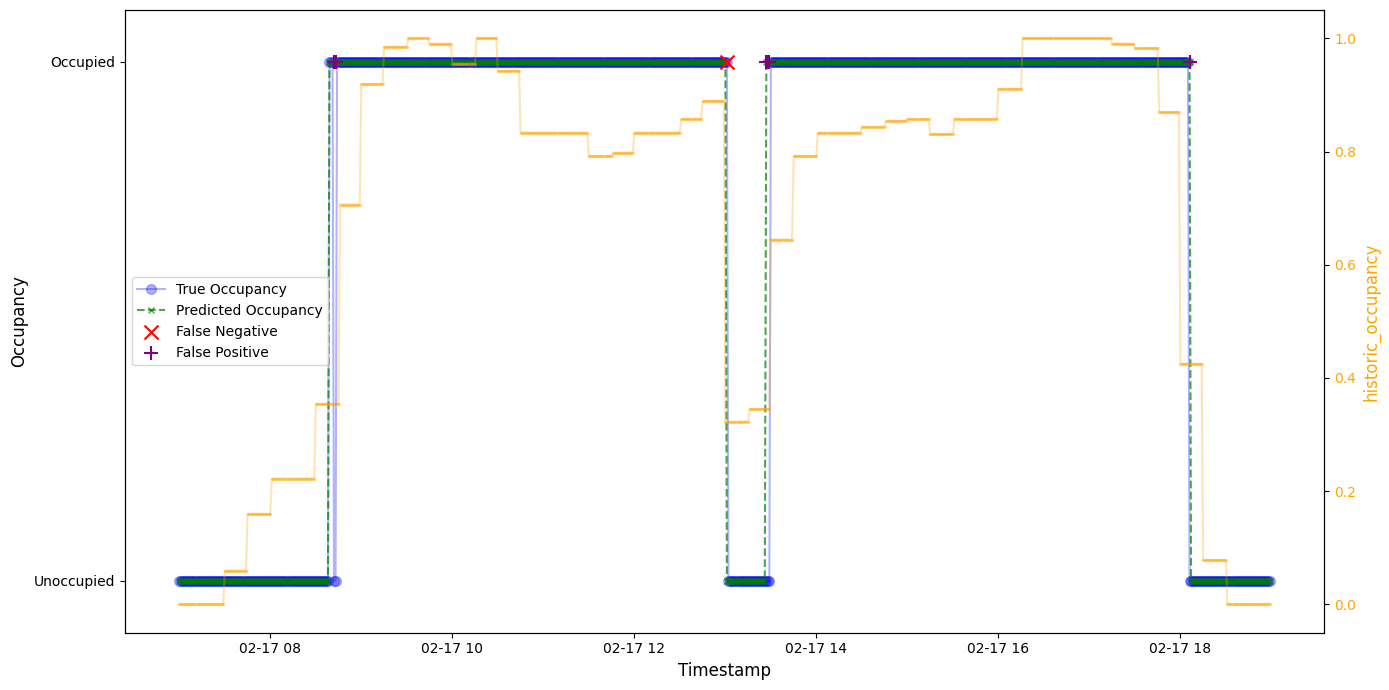


--- Test Set Misclassifications ---
Found classification errors on 4 days.
Date: 2015-02-02 / Day (07–19), Monday: 23 errors out of 281 records (8.19%)


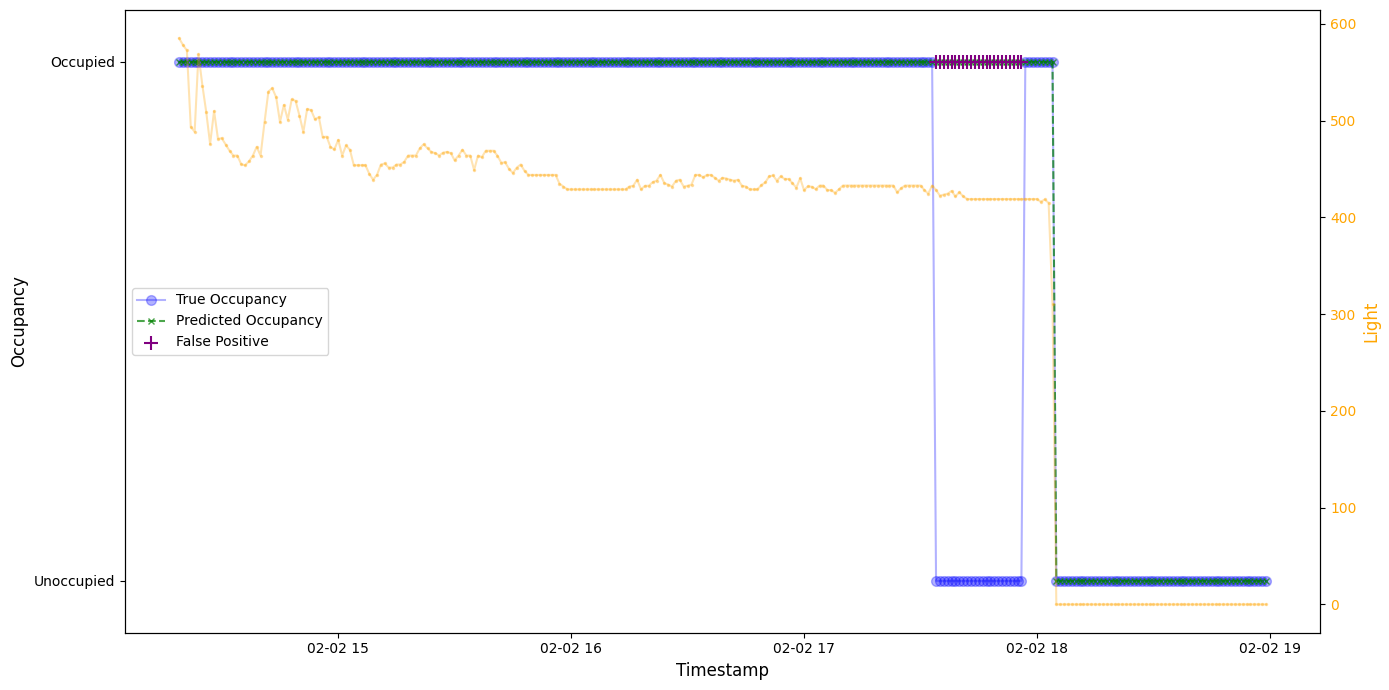

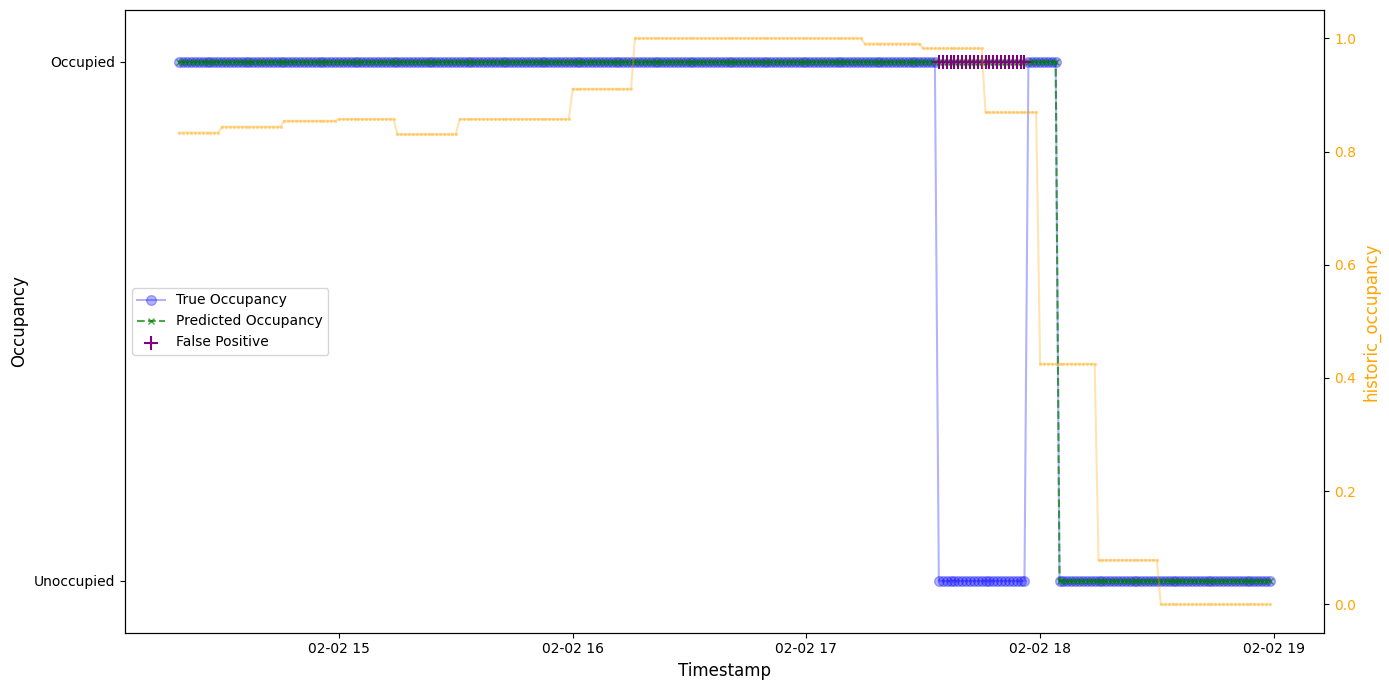

Date: 2015-02-03 / Day (07–19), Tuesday: 17 errors out of 720 records (2.36%)


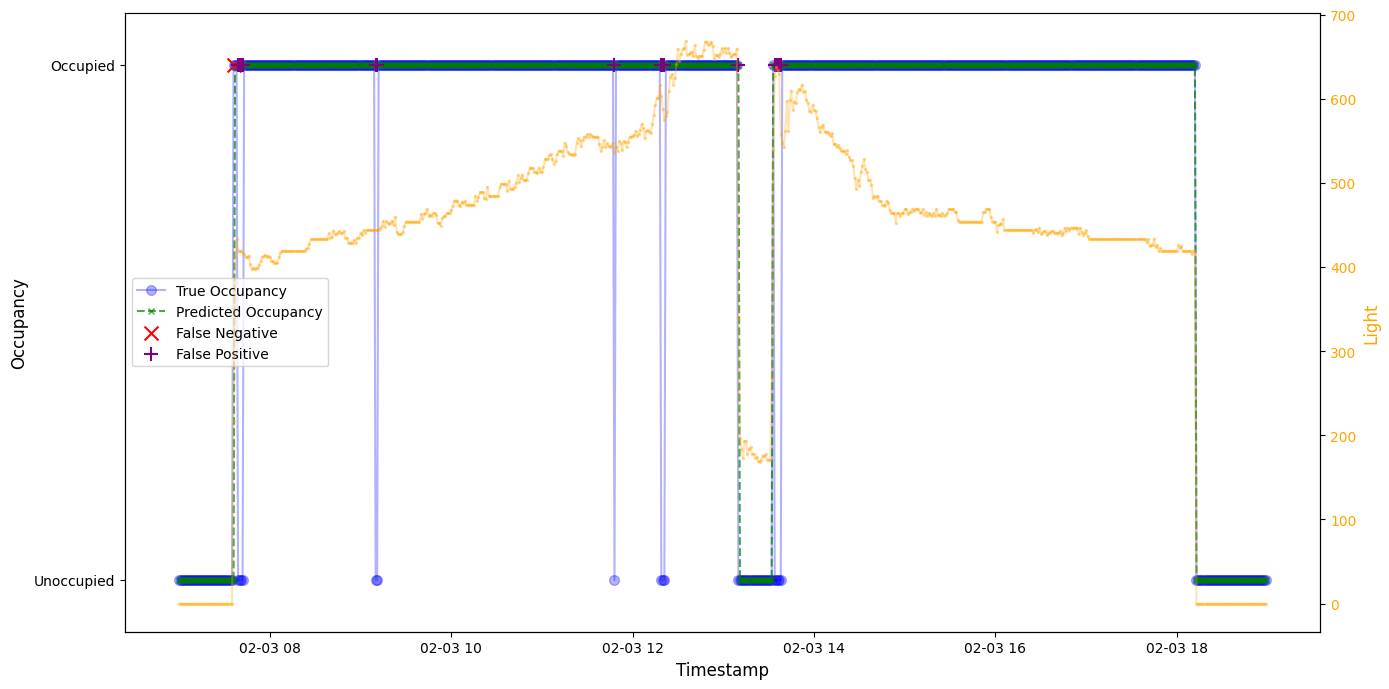

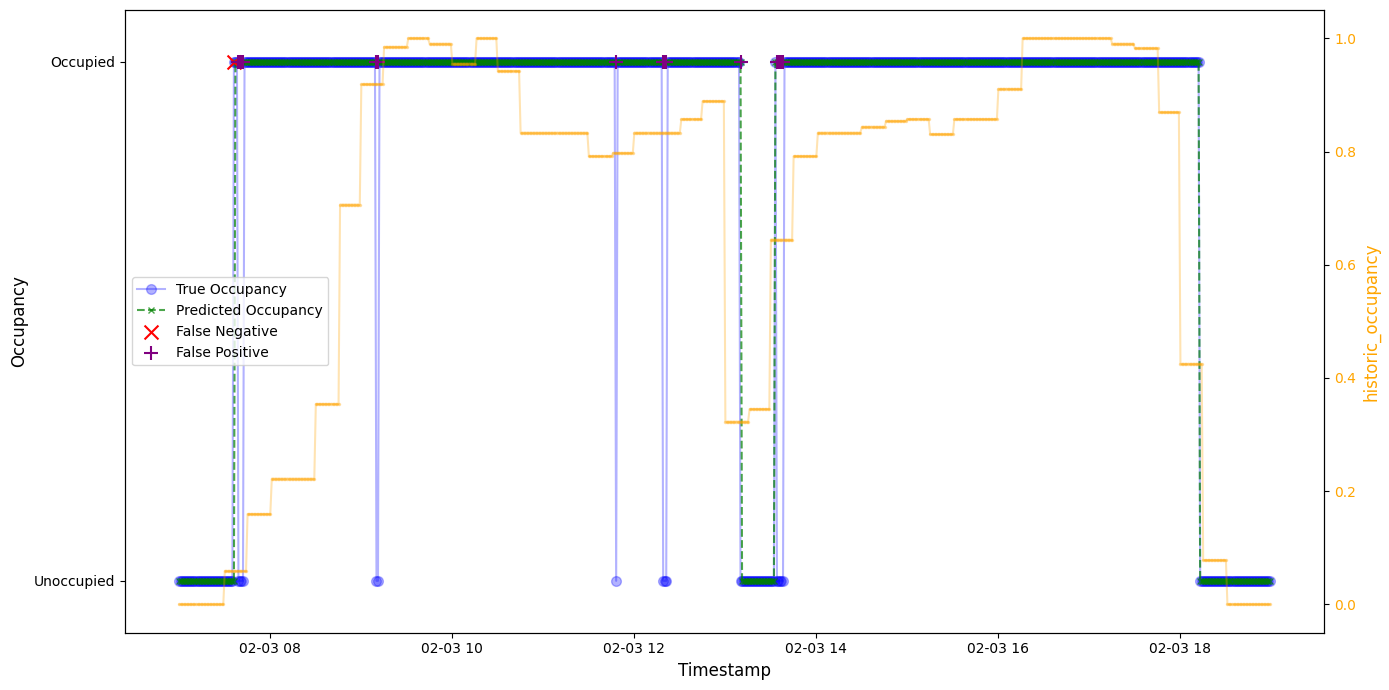

Date: 2015-02-05 / Day (07–19), Thursday: 65 errors out of 720 records (9.03%)


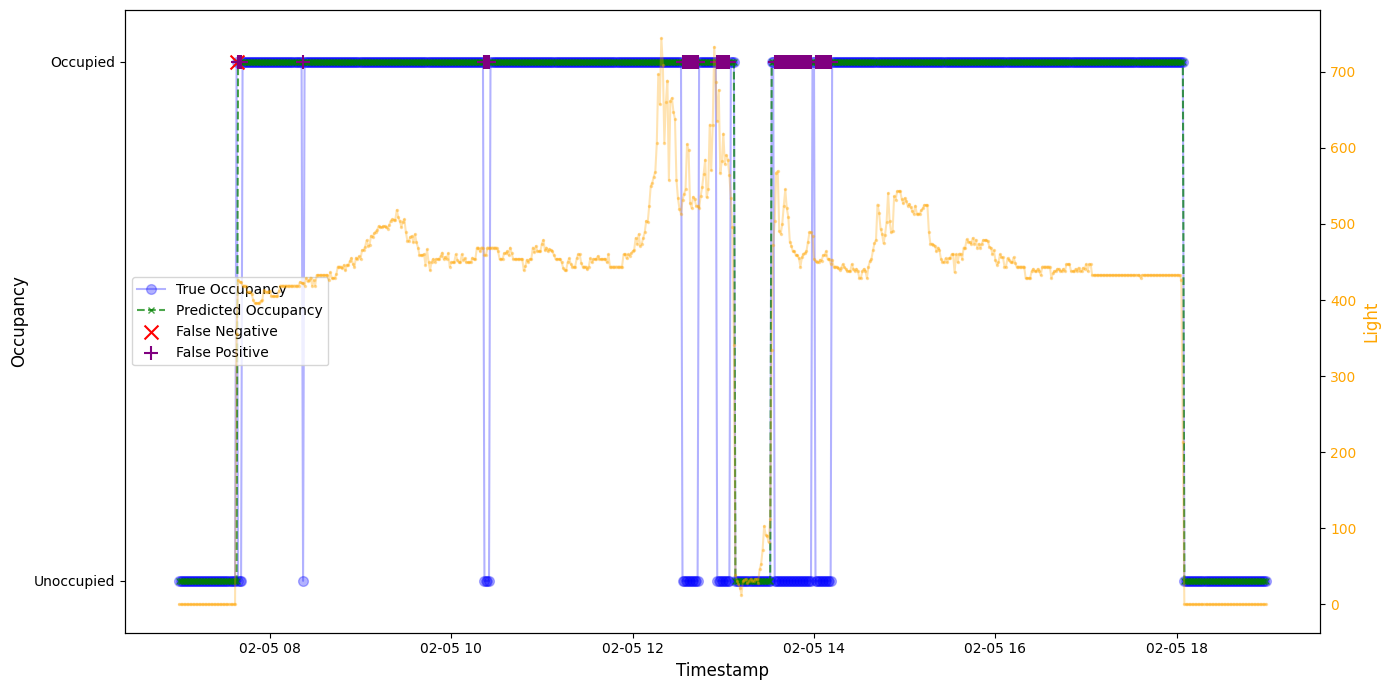

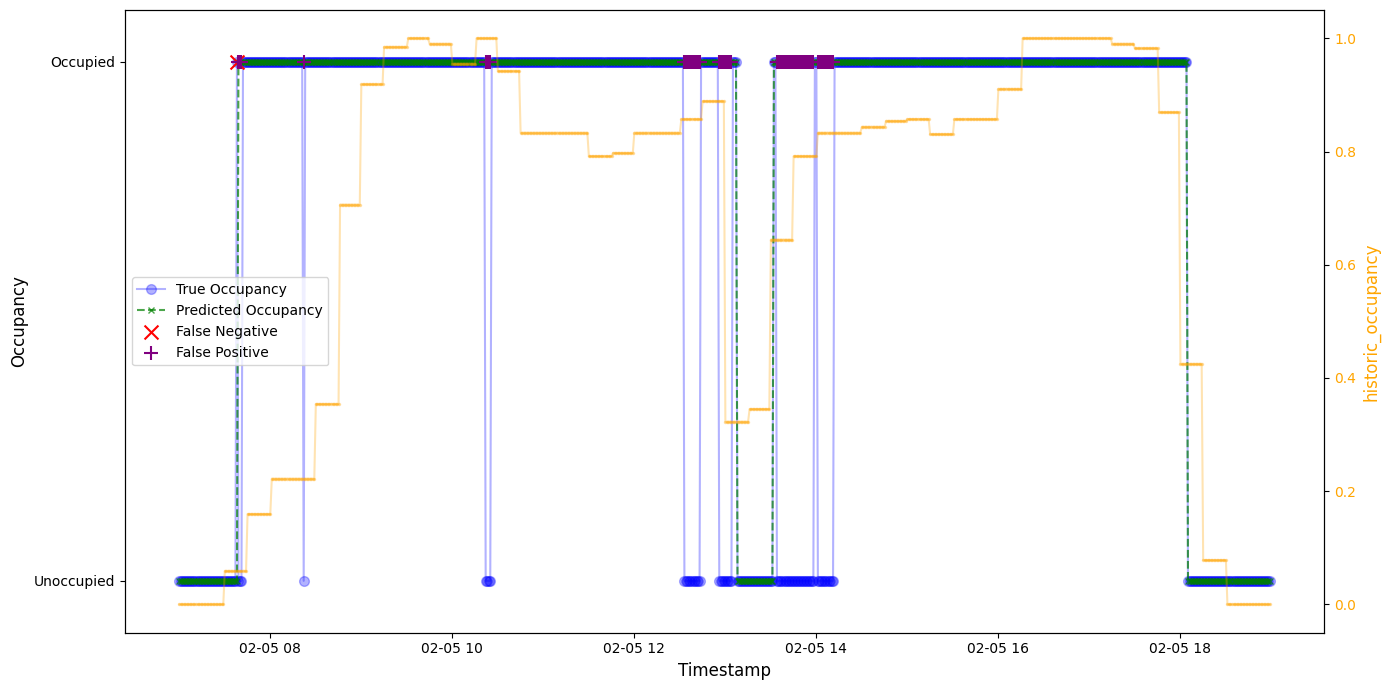

Date: 2015-02-15 / Day (07–19), Sunday: 5 errors out of 720 records (0.69%)


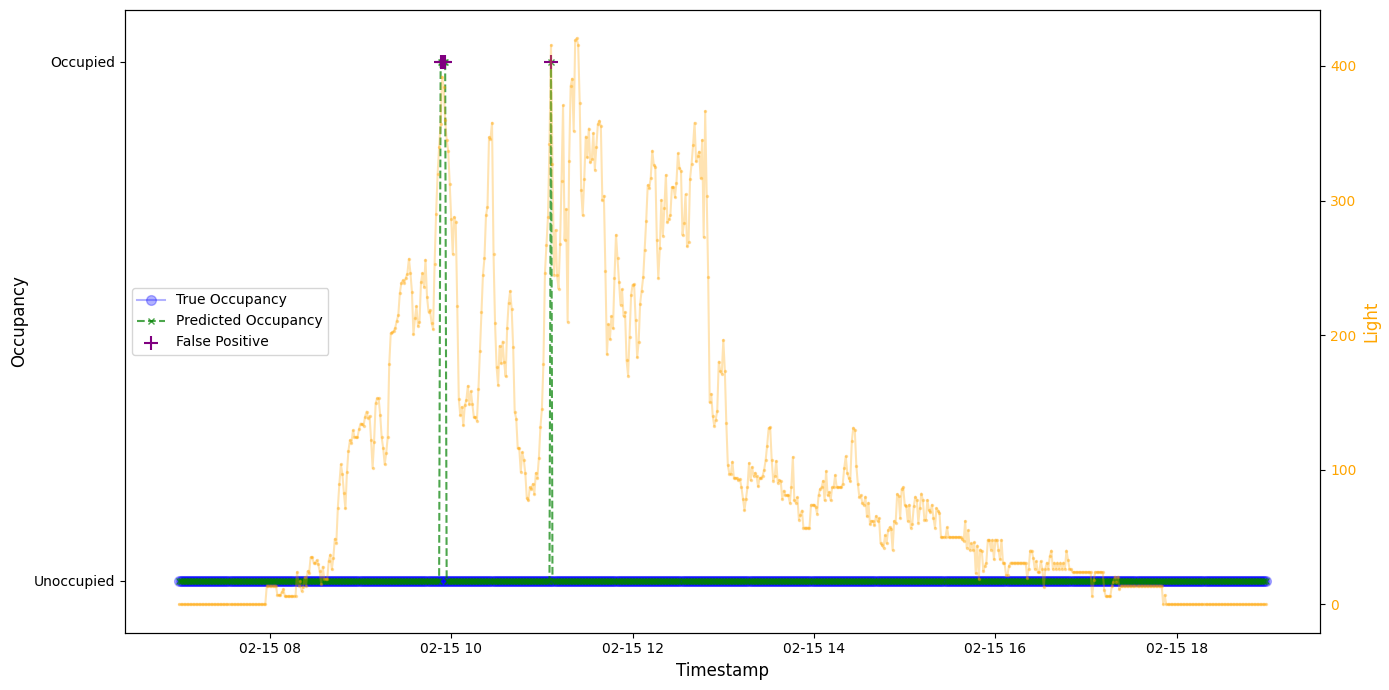

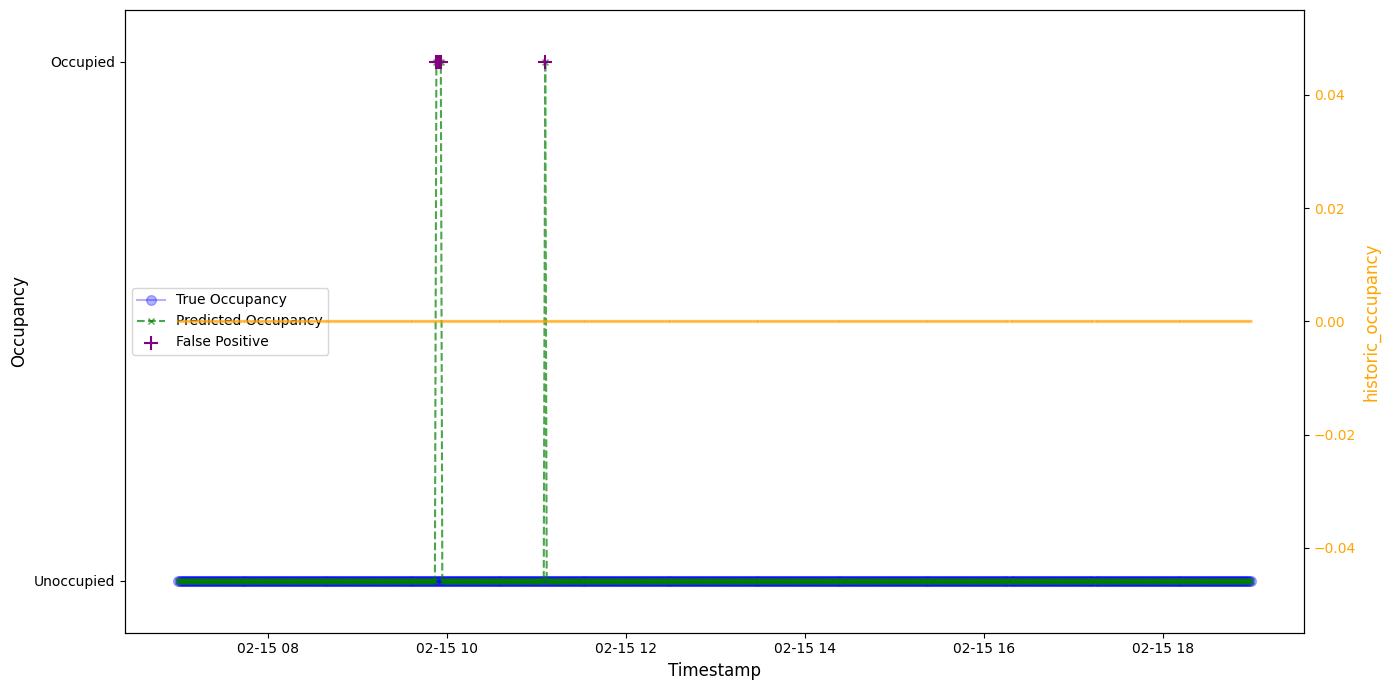

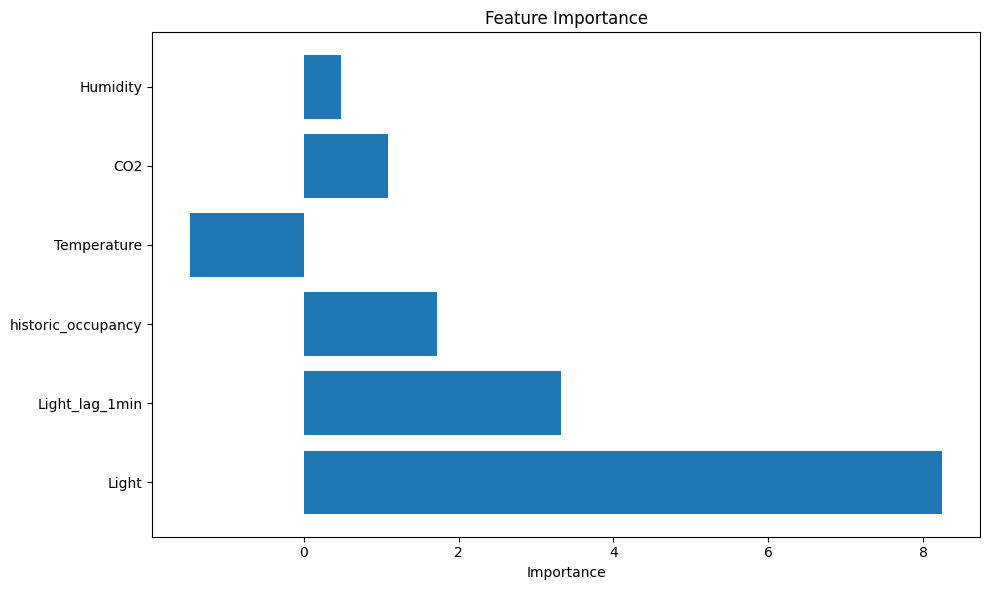

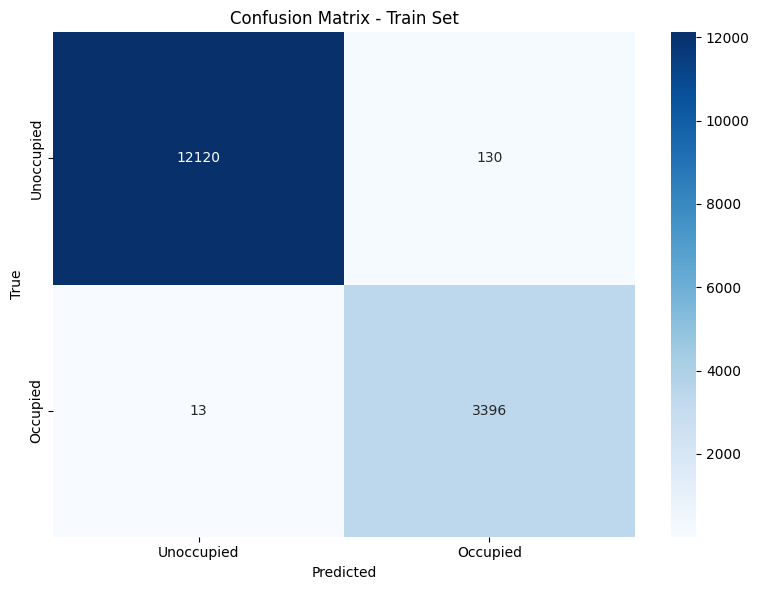

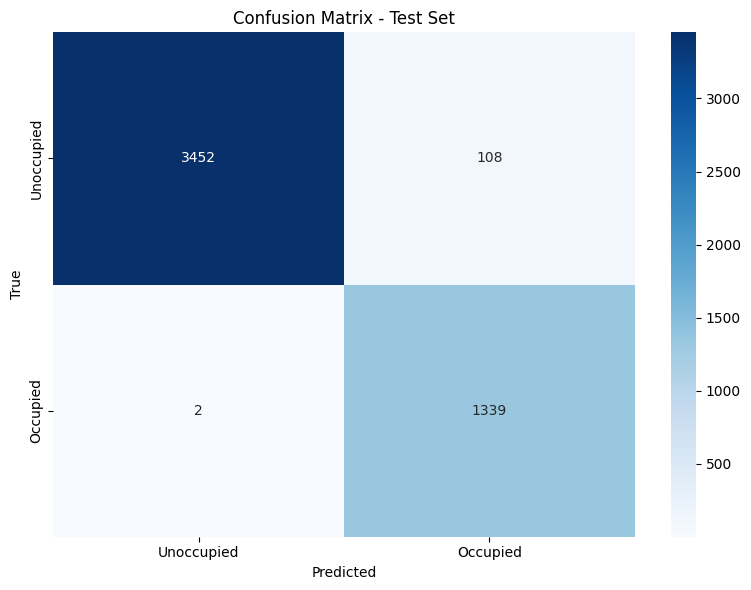

In [9]:
linear_eval_results = evaluate_and_visualize_model(best_linear_pipeline, X_train, y_train, X_val, y_val, train_idx=X_train.index, test_idx=X_val.index,
                            features_df=df, features_to_plot=['Light', 'historic_occupancy'])

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

sorted_df = pd.DataFrame(linear_cv_results).sort_values(by='rank_test_score', ascending=True)

display(sorted_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__solver,param_model__random_state,param_model__penalty,param_model__max_iter,param_model__class_weight,param_model__C,param_historic_feature__period_length,param_historic_feature__add_feature,param_feature_selector__feature_selection,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
29,0.419736,0.063205,0.077581,0.005806,saga,42,l1,3000,balanced,100.000,15,True,"[Light, CO2, Temperature, Humidity, Light_lag_...","{'model__solver': 'saga', 'model__random_state...",0.986055,0.966667,0.908252,0.986717,0.988817,0.967301,0.030590,1,0.974576,0.982629,0.986777,0.970806,0.966779,0.976314,0.007398
22,0.703562,0.108131,0.099620,0.025683,saga,42,l1,3000,None,10.000,30,True,"[Light, CO2]","{'model__solver': 'saga', 'model__random_state...",0.991848,0.965491,0.882682,0.991603,0.984844,0.963293,0.041435,2,0.971429,0.981247,0.984187,0.970960,0.969957,0.975556,0.005940
43,0.365229,0.077310,0.052196,0.003687,saga,42,l2,3000,None,100.000,30,True,"[Light, CO2]","{'model__solver': 'saga', 'model__random_state...",0.991848,0.965491,0.882682,0.991603,0.984844,0.963293,0.041435,2,0.971209,0.981017,0.984187,0.970719,0.969957,0.975418,0.005964
21,0.174786,0.031795,0.084471,0.031074,lbfgs,42,l2,3000,"{0: 1, 1: 2}",10.000,60,True,"[Light, CO2]","{'model__solver': 'lbfgs', 'model__random_stat...",0.991407,0.983000,0.861505,0.991225,0.988472,0.963122,0.050899,4,0.967403,0.971482,0.985958,0.965660,0.962963,0.970693,0.008119
44,0.243119,0.054633,0.069144,0.038780,saga,42,l1,3000,None,10.000,60,True,[Light],"{'model__solver': 'saga', 'model__random_state...",0.992297,0.983000,0.860098,0.990054,0.987559,0.962602,0.051345,5,0.973920,0.982860,0.984181,0.972046,0.971674,0.976936,0.005446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,0.146619,0.031124,0.000000,0.000000,saga,42,elasticnet,3000,balanced,0.010,15,True,"[Light, HumidityRatio, Light_lag_1min]","{'model__solver': 'saga', 'model__random_state...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.167637,0.045884,0.000000,0.000000,lbfgs,42,elasticnet,3000,"{0: 1, 1: 2}",0.001,30,True,"[Light, HumidityRatio, CO2, Temperature]","{'model__solver': 'lbfgs', 'model__random_stat...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,0.085604,0.005041,0.000000,0.000000,saga,42,elasticnet,3000,None,0.100,30,True,"[Light, HumidityRatio, CO2]","{'model__solver': 'saga', 'model__random_state...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,0.101823,0.006765,0.000000,0.000000,saga,42,elasticnet,3000,"{0: 1, 1: 2}",10.000,15,True,"[Light, Light_lag_1min]","{'model__solver': 'saga', 'model__random_state...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Temperature
linear_temp_params = {
    'model__C': np.logspace(-3, 3, 10), 
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': ['balanced'],
    'model__max_iter': [3000],
    'model__random_state': [42],
    'historic_feature__add_feature': [True, False],
    'historic_feature__period_length': [5, 15, 30, 60],
    'feature_selector__feature_selection': [temperature_features]
}

best_linear_temp_pipeline, linear_temp_cv_results, best_linear_temp_params, best_linear_temp_score = optimize_model_with_custom_splits(df_cv, 
                                features, target, cv_splitter, linear_pipeline, linear_temp_params, n_iter=20, n_jobs=-1,
                                  scoring='f1', random_state=42)

linear_temp_eval_results = evaluate_and_visualize_model(best_linear_temp_pipeline, X_train, y_train, X_val, y_val, train_idx=X_train.index, test_idx=X_val.index,
                            features_df=df, features_to_plot=['Temperature', 
                                                              'Temperature_rolling_mean_5min', 
                                                              'Temperature_roc_5min', 
                                                              'Temperature_rolling_change_mean_5min'])

In [ ]:
# Humidity
linear_hum_params = {
    'model__C': np.logspace(-3, 3, 10), 
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': ['balanced'],
    'model__max_iter': [3000],
    'model__random_state': [42],
    'historic_feature__add_feature': [True, False],
    'historic_feature__period_length': [5, 15, 30, 60],
    'feature_selector__feature_selection': [humidity_features]
}

best_linear_hum_pipeline, linear_hum_cv_results, best_linear_hum_params, best_linear_hum_score = optimize_model_with_custom_splits(df_cv, 
                                features, target, cv_splitter, linear_pipeline, linear_hum_params, n_iter=20, n_jobs=-1,
                                  scoring='f1', random_state=42)

linear_hum_eval_results = evaluate_and_visualize_model(best_linear_hum_pipeline, X_train, y_train, X_val, y_val, train_idx=X_train.index, test_idx=X_val.index,
                            features_df=df, features_to_plot=['Humidity', 
                                                              'Humidity_rolling_mean_5min', 
                                                              'Humidity_roc_5min', 
                                                              'Humidity_rolling_change_mean_5min'])

In [ ]:
# Light
linear_light_params = {
    'model__C': np.logspace(-3, 3, 10), 
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': ['balanced'],
    'model__max_iter': [3000],
    'model__random_state': [42],
    'historic_feature__add_feature': [True, False],
    'historic_feature__period_length': [5, 15, 30, 60],
    'feature_selector__feature_selection': [light_features]
}

best_linear_light_pipeline, linear_light_cv_results, best_linear_light_params, best_linear_light_score = optimize_model_with_custom_splits(df_cv, 
                                features, target, cv_splitter, linear_pipeline, linear_light_params, n_iter=20, n_jobs=-1,
                                  scoring='f1', random_state=42)

linear_light_eval_results = evaluate_and_visualize_model(best_linear_light_pipeline, X_train, y_train, X_val, y_val, train_idx=X_train.index, test_idx=X_val.index,
                            features_df=df, features_to_plot=['Light', 
                                                              'Light_rolling_mean_5min', 
                                                              'Light_roc_5min', 
                                                              'Light_rolling_change_mean_5min'])

In [ ]:
# CO2
linear_co2_params = {
    'model__C': np.logspace(-3, 3, 10), 
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': ['balanced'],
    'model__max_iter': [3000],
    'model__random_state': [42],
    'historic_feature__add_feature': [True, False],
    'historic_feature__period_length': [5, 15, 30, 60],
    'feature_selector__feature_selection': [co2_features]
}

best_linear_co2_pipeline, linear_co2_cv_results, best_linear_co2_params, best_linear_co2_score = optimize_model_with_custom_splits(df_cv, 
                                features, target, cv_splitter, linear_pipeline, linear_co2_params, n_iter=20, n_jobs=-1,
                                  scoring='f1', random_state=42)

linear_co2_eval_results = evaluate_and_visualize_model(best_linear_co2_pipeline, X_train, y_train, X_val, y_val, train_idx=X_train.index, test_idx=X_val.index,
                            features_df=df, features_to_plot=['CO2', 
                                                              'CO2_rolling_mean_5min', 
                                                              'CO2_roc_5min', 
                                                              'CO2_rolling_change_mean_5min'])

In [ ]:
# HumidityRatio
linear_humr_params = {
    'model__C': np.logspace(-3, 3, 10), 
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': ['balanced'],
    'model__max_iter': [3000],
    'model__random_state': [42],
    'historic_feature__add_feature': [True, False],
    'historic_feature__period_length': [5, 15, 30, 60],
    'feature_selector__feature_selection': [humidity_ratio_features]
}

best_linear_humr_pipeline, linear_humr_cv_results, best_linear_humr_params, best_linear_humr_score = optimize_model_with_custom_splits(df_cv, 
                                features, target, cv_splitter, linear_pipeline, linear_humr_params, n_iter=20, n_jobs=-1,
                                  scoring='f1', random_state=42)

linear_humr_eval_results = evaluate_and_visualize_model(best_linear_humr_pipeline, X_train, y_train, X_val, y_val, train_idx=X_train.index, test_idx=X_val.index,
                            features_df=df, features_to_plot=['HumidityRatio', 
                                                              'HumidityRatio_rolling_mean_5min', 
                                                              'HumidityRatio_roc_5min', 
                                                              'HumidityRatio_rolling_change_mean_5min'])